# Introduction

![Kitchen](images/Food-Safety-Introduction.jpeg)

![Kitchen](images/Food-Safety-Introduction.jpeg)

Cities across the United States are capitalizing on  data. Predictive modeling is becoming a prominent tool for public safety in many cities where the local authority can target interventions. These preventative measures range from predicting which landlords are not complying with city ordinances to which buildings pose the highest risk of fire so they can send inspectors out and prevent an outbreak before it happens.

According to the CDC, more than 48 million Americans per year become sick from food, and an estimated 75% of the outbreaks came from food prepared by caterers, delis, and restaurants. In most cities, health inspections are generally random, which can increase time spent on spot checks at clean restaurants that have been following the rules closely — and missed opportunities to improve health and hygiene at places with more pressing food safety issues.

## Objective

The goal for this project is to leverage public citizen generated data from social media to narrow the search for critical health and safety violations in New York City. As the City of New York manages  an open data portal, everyone can access historical hygiene inspections and violation records. By combine these two data source this project aims to determine which words, phrases, ratings, and patterns among restaurants lead to critical health and safety violations. This model can assist city health inspectors do their job better by prioritizing the kitchens most likely to be in violation of code.

The New York Health Department inspects the approximately 27,000 restaurants within the city to monitor their compliance with food safety regulations. Inspectors observe how food is prepared, served and stored and whether restaurant workers are practicing good hygiene. They check food temperatures, equipment maintenance and pest control measures.

### Imports

In [2]:
from IPython import display
from bs4 import BeautifulSoup as bs
import requests
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import plotly.express as px

import warnings
import time

import folium
import folium.plugins as plugins

# misc
import glob, os
import ast

call_apis = False
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth',200)
pd.set_option('display.max_columns',50)
pd.options.display.float_format = '{:.2f}'.format

from sklearn.preprocessing import OneHotEncoder

#NLP 
import spacy
nlp = spacy.load("en_core_web_lg")
from spacy import displacy
import nltk 
import string
from nltk.collocations import *
from nltk import word_tokenize,wordpunct_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from nltk import word_tokenize
#nltk.download('wordnet')

# sk-learn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Deep Learning
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import text,sequence
from keras_preprocessing.sequence import pad_sequences




In [3]:
# # LIME
# from lime import lime_text
# from lime.lime_text import LimeTextExplainer
# from sklearn.pipeline import make_pipeline
# from lime.lime_text import IndexedString,IndexedCharacters
# from lime.lime_base import LimeBase
# from sklearn.linear_model import Ridge, lars_path
# from lime.lime_text import explanation
# from functools import partial
# import scipy as sp
# from sklearn.utils import check_random_state

# Obtain

This project utilises 3 data sources:
* Historical health and hygiene inspections recorded by New York City Department of Health and Mental Hygiene (DOHMH) public health inspectors
* Yelp API business data and ratings 
* Yelp user generateda reviews

Since 2010, New York City has required restaurants to post letter grades that correspond to scores received from sanitary inspections.Since 2010, New York City has required restaurants to post letter grades that correspond to scores received from sanitary inspections.

>* "A" grade: 0 to 13 points for sanitary violations
>* "B" grade: 14 to 27 points for sanitary violations
>* "C" grade: 28 or more points for sanitary violations


## Obtaining Restaurant Inspection Results from NYC Open Data Portal

The dataset can be obtained here

https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j

The dataset was downloaded and saved to this repository. Let's load it in and explore its contents.

Detailed descriptions about each column can be found in the Restaurant Inspection Data Dictionary.

In [4]:
doh_df = pd.read_csv('data/nyc_open_data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv')
doh_df

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,50008319,POULETTE,Manhattan,790,9 AVENUE,10019.00,2129569488,Chicken,01/28/2019,Violations were cited in the following area(s).,04D,"Food worker does not wash hands thoroughly after using the toilet, coughing, sneezing, smoking, eating, preparing raw foods or otherwise contaminating hands.",Critical,22,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.77,-73.99,104.00,3.00,13300.00,1025235.00,1010430004.00,MN15
1,41678734,TINY'S DINER,Bronx,3603,RIVERDALE AVENUE,10463.00,7187087600,American,09/23/2019,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or non-food areas.,Critical,24,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.89,-73.91,208.00,11.00,29500.00,2084186.00,2057960167.00,BX29
2,40795021,TAO RESTAURANT,Manhattan,42,EAST 58 STREET,10022.00,2128882288,Asian/Asian Fusion,03/11/2020,Violations were cited in the following area(s).,10F,"Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to al...",Not Critical,9,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.76,-73.97,105.00,4.00,11202.00,1036073.00,1012930047.00,MN17
3,40795021,TAO RESTAURANT,Manhattan,42,EAST 58 STREET,10022.00,2128882288,Asian/Asian Fusion,03/11/2020,Violations were cited in the following area(s).,10F,"Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to al...",Not Critical,9,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.76,-73.97,105.00,4.00,11202.00,1036073.00,1012930047.00,MN17
4,40538234,"DUNKIN',' BASKIN ROBBINS",Queens,9925,HORACE HARDING EXPRESSWAY,11368.00,7182719222,Donuts,07/29/2021,Violations were cited in the following area(s).,06E,"Sanitized equipment or utensil, including in-use food dispensing utensil, improperly used or stored.",Critical,10,A,07/29/2021,03/24/2022,Cycle Inspection / Initial Inspection,40.74,-73.86,404.00,21.00,43702.00,4047915.00,4019480019.00,QN25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186222,41556790,FIVE GUYS FAMOUS BURGERS AND FRIES,Manhattan,2847,BROADFWAY,NaN,2126787701,Hamburgers,03/01/2019,Violations were cited in the following area(s).,10F,"Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to al...",Not Critical,3,A,03/01/2019,03/24/2022,Cycle Inspection / Initial Inspection,0.00,0.00,NaN,NaN,NaN,NaN,1.00,NaN
186223,50032876,TANNER SMITH'S,Manhattan,204,WEST 55 STREET,10019.00,9175172283,American,06/07/2019,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.,Not Critical,12,A,06/07/2019,03/24/2022,Cycle Inspection / Initial Inspection,40.76,-73.98,105.00,4.00,13700.00,1024857.00,1010260037.00,MN17
186224,50003842,T- 45,Manhattan,135,WEST 45 STREET,10036.00,6466403775,American,07/26/2018,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained; anti-siphonage or backflow prevention device not provided where required; equipment or floor not properly drained; sewage disposal system in disrepai...,Not Critical,49,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.76,-73.98,105.00,4.00,11900.00,1089796.00,1009980015.00,MN17
186225,41640824,RICURAS ECUADORIAN BAKERY,Bronx,1576,WATSON AVENUE,10472.00,

The dataset contains 186,227 inspection results. However, when an inspection results in more than one violation, values for associated fields are repeated for each additional violation record. So let's check how many individual restaurants are in the dataset.

### Understanding NYC DOHMH Data

In [5]:
# How many unique restaurants are in this dataset?
n_unique = doh_df['CAMIS'].nunique()
print(f'There are {n_unique} unique restaurants in the dataset. ')

There are 19792 unique restaurants in the dataset. 


In [6]:
# Get more information about the dataset contents
doh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186227 entries, 0 to 186226
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  186227 non-null  int64  
 1   DBA                    186200 non-null  object 
 2   BORO                   186227 non-null  object 
 3   BUILDING               185799 non-null  object 
 4   STREET                 186227 non-null  object 
 5   ZIPCODE                183146 non-null  float64
 6   PHONE                  186214 non-null  object 
 7   CUISINE DESCRIPTION    186226 non-null  object 
 8   INSPECTION DATE        186227 non-null  object 
 9   ACTION                 186227 non-null  object 
 10  VIOLATION CODE         185413 non-null  object 
 11  VIOLATION DESCRIPTION  185863 non-null  object 
 12  CRITICAL FLAG          186227 non-null  object 
 13  SCORE                  186227 non-null  int64  
 14  GRADE                  67933 non-nul

In [7]:
doh_df['ZIPCODE'].astype(str)

0         10019.0
1         10463.0
2         10022.0
3         10022.0
4         11368.0
           ...   
186222        nan
186223    10019.0
186224    10036.0
186225    10472.0
186226    10461.0
Name: ZIPCODE, Length: 186227, dtype: object

In [8]:
doh_df['Community Board'].astype(str)

0         104.0
1         208.0
2         105.0
3         105.0
4         404.0
          ...  
186222      nan
186223    105.0
186224    105.0
186225    209.0
186226    210.0
Name: Community Board, Length: 186227, dtype: object

In [9]:
doh_df['Council District'].astype(str)

0          3.0
1         11.0
2          4.0
3          4.0
4         21.0
          ... 
186222     nan
186223     4.0
186224     4.0
186225    18.0
186226    13.0
Name: Council District, Length: 186227, dtype: object

In [10]:
doh_df['Census Tract'].astype(str)

0         13300.0
1         29500.0
2         11202.0
3         11202.0
4         43702.0
           ...   
186222        nan
186223    13700.0
186224    11900.0
186225     5001.0
186226    30000.0
Name: Census Tract, Length: 186227, dtype: object

Every row has a restaurant ID, address, date, and score. Let's ensure there aren't any duplicated rows.

In [11]:
print(f'There are {doh_df.duplicated(keep=False).sum()} duplicated rows. ')

There are 22010 duplicated rows. 


In [12]:
# Let's drop these duplucated rows
doh_df.drop_duplicates(keep='first',inplace=True)

In [13]:
# Confirming duplicates have been removed
doh_df.shape

(174725, 26)

Since this project will be leveraging data publicly generated from social media a lookup value will be needed to call the API and join the tables. The Yelp API has an endpoint for Phone Search. This will allow us to pull Yelp business data for each restaurant by proivinging a telephone number. More infomration can be found in the [documentation here.](https://www.yelp.com/developers/documentation/v3/business_search_phone)

In [14]:
# Checking that every restaunt has a phone number
missing_num = doh_df['PHONE'].isna().sum()
print(f'There are {missing_num} restaunts missing a telephone number.')

There are 13 restaunts missing a telephone number.


In [15]:
# Since only 13 numbers are missing, these rows can be dropped
doh_df.dropna(subset=['PHONE'],inplace=True)

In [16]:
# Confirming records were dropped
doh_df['PHONE'].isna().sum()

0

In [17]:
# How many unique restaurants are remaining?
n_unique = doh_df['CAMIS'].nunique()
print(f'There are {n_unique} unique restaurants remaining in the dataset. ')

There are 19790 unique restaurants remaining in the dataset. 


Let's explore the date range for this dataset.

In [18]:
doh_df['INSPECTION DATE'] =  pd.to_datetime(doh_df['INSPECTION DATE'])
begin_date = doh_df['INSPECTION DATE'].min()
end_date = doh_df['INSPECTION DATE'].max()
print(f'The data ranges from {begin_date} to {end_date}')

The data ranges from 2009-05-16 00:00:00 to 2022-03-23 00:00:00


Inspections in this dataset range from May 2009 up to March 2022.

### Target Variable -- NYCDOH Inspection Grades

Health code violations found during an inspections carries a point value, and a restaurant’s score corresponds to a letter grade. A lower point score, leads to a better letter grade:

* "A" grade: 0 to 13 points for sanitary violations
* "B" grade: 14 to 27 points for sanitary violations
* "C" grade: 28 or more points for sanitary violations

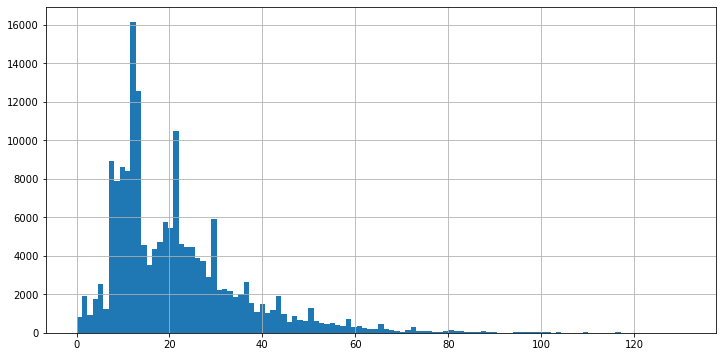

In [19]:
# Let see what the score distribution is
doh_df['SCORE'].hist(bins=113, figsize=(12,6));

In [20]:
doh_df['SCORE'].describe()

count   174712.00
mean        21.36
std         14.36
min          0.00
25%         12.00
50%         18.00
75%         27.00
max        131.00
Name: SCORE, dtype: float64

### Engineering Target Variable

Because the inspections dataset contains many duplicated businesses in its records, this project will group records by businesses and get a count for each for their letter grades. The target variable will be finding restaurants that have received 1 or more C Grades.

In [21]:
# Copying to a new DateFrame
doh_graded = doh_df.copy()

In [22]:
# Dropping nonrequired features
doh_graded.drop(columns=['INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG','GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE'],inplace=True)

In [23]:
# Creating new columns with NYCDOH Grades
doh_graded['A'] = (doh_graded['SCORE'] < 14).astype(int)
doh_graded['B'] = (doh_graded['SCORE'] > 13).astype(int) & (doh_df['SCORE'] < 28).astype(int)
doh_graded['C'] = (doh_graded['SCORE'] > 27).astype(int)

In [24]:
# Creating a new DF and grouping businesses and summing their Grade counts
doh_grouped = doh_graded.groupby(by=['CAMIS', 'DBA','CUISINE DESCRIPTION',
                                     'BORO', 'BUILDING',
                                     'STREET', 'ZIPCODE', 'PHONE', 'Latitude',
                                     'Longitude', 'Community Board',
                                     'Council District','Census Tract'],dropna=False)['A','B','C'].sum()

In [25]:
# Checking the number of businesses that have received 1 or more B Grades
(doh_grouped['B'] > 0).sum()

9977

Of the 19,790 unique restaurants, 9,977 failed an initial cycle inspection at least once.

In [26]:
# Checking the number of businesses that have received 1 or more C Grades
(doh_grouped['C'] > 0).sum()

5648

Of the 19,790 unique restaurants, 5,648 severly failed an initial cycle inspection at least once and are at risk of being closed by the DOHMH.

In [27]:
# Creating the Target Variable 'Severe' for Restaurants that have scored over 28 points in an initial inspection.
doh_grouped['Severe'] = (doh_grouped['C'] > 0).astype(int)
nyc_df = doh_grouped.reset_index()
nyc_df.drop(['A','B','C'],axis=1, inplace=True)

In [28]:
# Checking out the new DF with the engineered target variable
nyc_df

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe
0,30075445,MORRIS PARK BAKE SHOP,Bakery Products/Desserts,Bronx,1007,MORRIS PARK AVENUE,10462.00,7188924968,40.85,-73.86,211.00,13.00,25200.00,0
1,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,11225.00,7182875005,40.66,-73.96,309.00,40.00,32700.00,0
2,30191841,DJ REYNOLDS PUB AND RESTAURANT,Irish,Manhattan,351,WEST 57 STREET,10019.00,2122452912,40.77,-73.98,104.00,3.00,13900.00,0
3,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,11224.00,7183723031,40.58,-73.98,313.00,47.00,34800.00,0
4,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,11234.00,7184443838,40.62,-73.91,318.00,46.00,70000.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19785,50115169,Sobak,Korean,Manhattan,51,CANAL STREET,10002.00,9294018597,40.71,-73.99,103.00,1.00,1600.00,0
19786,50116155,SEPTEMBER,Coffee/Tea,Brooklyn,83,SARATOGA AVENUE,11233.00,5086491703,40.68,-73.92,316.00,41.00,37300.00,0
19787,50117350,SONG TEA,Coffee/Tea,Manhattan,488,7 AVENUE,10018.00,6466697802,40.75,-73.99,105.00,3.00,10900.00,0
19788,50117434,LA POLLERA COLORADA,Spanish,Queens,8213,NORTHERN BLVD,11372.00,7184246531,40.76,-73.89,403.00,25.00,32700.00,1


#### NYC DOH Data Exploration

In [29]:
nyc_df['BORO'].value_counts()

Manhattan        7892
Brooklyn         4801
Queens           4468
Bronx            1920
Staten Island     704
0                   5
Name: BORO, dtype: int64

In [30]:
nyc_df['CUISINE DESCRIPTION'].value_counts()

American             4269
Chinese              1716
Coffee/Tea           1316
Pizza                1249
Italian               829
                     ... 
Iranian                 3
Fruits/Vegetables       2
Fusion                  1
Chilean                 1
Basque                  1
Name: CUISINE DESCRIPTION, Length: 84, dtype: int64

In [31]:
nyc_df['ZIPCODE'].value_counts()

10019.00    513
10036.00    469
10003.00    463
10001.00    367
10022.00    359
           ... 
10115.00      1
10173.00      1
10285.00      1
10177.00      1
10069.00      1
Name: ZIPCODE, Length: 221, dtype: int64

## Obtaining Yelp Buniness and Review Data

Now that we have an understanding of the city's inspection results and have explored that dataset it is time to pull in data from the crowd-sourced review platform Yelp.

In [32]:
# Loading in locally stored API credentials. 
# You can sign up for access and obtain credentials to the Yelp API here: 
# https://www.yelp.com/developers/documentation/v3

with open('/Users/Rob/.secret/yelp_api.json') as f:
    creds = json.load(f)

In [33]:
# Checking creds were properly loaded in
creds.keys()

dict_keys(['api_key'])

### Yelp Business Search

In [34]:
# Formatting phone numbers provided in the NYCDOH dataset 
nyc_df['PHONE'] = '+1'+nyc_df['PHONE']

# Ensure the list contains unique phone numbers only
phone_numbers = set(nyc_df['PHONE'])
phone_numbers = list(phone_numbers)
number_count = len(phone_numbers)
print(f'There are {number_count} unique phone numbers.')

There are 18937 unique phone numbers.


So we will call the Yelp API at the Phone Search Endpoint for all the numbers in the `phone_numbers` list. However the API only allows 5000 callers per day so we'll slice the list into smaller list.

In [35]:
# Slicing the phone list into smaller list to fit under the API daily limit restrictions
# phone_numbers1 = phone_numbers[1:1000]
# phone_numbers2 = phone_numbers[1000:2000]
# phone_numbers3 = phone_numbers[2000:2500]
# phone_numbers4 = phone_numbers[2500:3500]
# phone_numbers5 = phone_numbers[3500:5000]
# phone_numbers6 = phone_numbers[5000:6000]
# phone_numbers7 = phone_numbers[6000:7500]
# phone_numbers8 = phone_numbers[7500:10000]
# phone_numbers9 = phone_numbers[10000:12500]
# phone_numbers11 = phone_numbers[15000:17500]
# phone_numbers12 = phone_numbers[17500:20000]
# phone_numbers9 = phone_numbers[10000:12500]
# phone_numbers10 = phone_numbers[12500:15000]
# phone_numbers11 = phone_numbers[15000:17500]
# phone_numbers12 = phone_numbers[17500:19000]

In [36]:
#Functionizing the Yelp API Phone Search

def get_businesses(phone_numbers):
    """Input a list of formatted phone numbers
    (must start with + and include the country code, like +14159083801)
    and returns a corresponding list of Yelp Businesses"""
    
    biz_list = []
    
    for number in phone_numbers:
        url = 'https://api.yelp.com/v3/businesses/search/phone'
        headers = {'Authorization': 'Bearer ' + creds['api_key']}
        url_params = {'phone': number}
        response = requests.get(url, headers=headers, params=url_params)
        response_json = response.json()
        biz_list.extend(response_json.get('businesses','U'))
        
    while 'U' in biz_list:
        biz_list.remove('U')
        
    return biz_list

In [37]:
# Call `get_business` function
if call_apis == True:
    biz_list12 = get_businesses(phone_numbers12)
    
    # Save returned list as a DataFrame and .csv file
    biz12_df = pd.DataFrame(biz_list12)
    biz12_df.to_csv('data/yelp_data/yelp_business/yelp_phone12.csv',index=False)

In [38]:
# List of files containing Yelp business data
fpath = 'data/yelp_data/yelp_businesses/'
os.listdir(fpath)
query = fpath+"*.csv"
f_list = glob.glob(query)

In [39]:
# Append saved Yelp Business tables to a dict
yelp_tables = {}

for f in f_list:
    temp_df = pd.read_csv(f)
    fname = f.replace('data/yelp_data/yelp_businesses/yelp_phone','df_').replace('.csv','')
    yelp_tables[fname] = temp_df

In [40]:
yelp_df_list = [t for t in list(yelp_tables.keys())]

In [41]:
# Concatenating all Yelp Businesses responses from the Phone Search
yelp_businesses_df = pd.concat(yelp_tables,ignore_index=True)
yelp_businesses_df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone
0,RzKR9QcYP03EQ_8DxTxowg,barrio-chino-new-york,Barrio Chino,https://s3-media0.fl.yelpcdn.com/bphoto/dpaRqPZD6xqDZo2ZfOyjnQ/o.jpg,False,https://www.yelp.com/biz/barrio-chino-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,1148,"[{'alias': 'mexican', 'title': 'Mexican'}, {'alias': 'bars', 'title': 'Bars'}]",4.00,"{'latitude': 40.718022, 'longitude': -73.990026}","['delivery', 'pickup']",$$,"{'address1': '253 Broome St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': '10002', 'country': 'US', 'state': 'NY', 'display_address': ['253 Broome St', 'New York, NY 10002']}",12122286710,(212) 228-6710
1,hrP3xLWJ8sLwG_XxEGq61Q,reyes-restaurant-woodside,Reyes Restaurant,https://s3-media0.fl.yelpcdn.com/bphoto/_dwQGccROJaxa-oNIxQsEg/o.jpg,False,https://www.yelp.com/biz/reyes-restaurant-woodside?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,7,"[{'alias': 'latin', 'title': 'Latin American'}, {'alias': 'dominican', 'title': 'Dominican'}]",4.00,"{'latitude': 40.7466, 'longitude': -73.9098}",['delivery'],$,"{'address1': '4754 46th St', 'address2': '', 'address3': '', 'city': 'Woodside', 'zip_code': '11377', 'country': 'US', 'state': 'NY', 'display_address': ['4754 46th St', 'Woodside, NY 11377']}",17187529577,(718) 752-9577
2,in7QM4vNUTHVZIi7Outetg,mcdonalds-new-york-430,McDonald's,https://s3-media0.fl.yelpcdn.com/bphoto/bNmu8D1sjwJzbxxP9ZwJOQ/o.jpg,False,https://www.yelp.com/biz/mcdonalds-new-york-430?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,103,"[{'alias': 'burgers', 'title': 'Burgers'}, {'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'coffee', 'title': 'Coffee & Tea'}]",1.50,"{'latitude': 40.7163213865248, 'longitude': -74.0106988300204}",['delivery'],$,"{'address1': '167 Chambers St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10007', 'country': 'US', 'state': 'NY', 'display_address': ['167 Chambers St', 'New York, NY 10007']}",12126082405,(212) 608-2405
3,F-YGKegXRG2TE-Xw1AWeCA,popeyes-louisiana-kitchen-rockaway-beach-2,Popeyes Louisiana Kitchen,https://s3-media0.fl.yelpcdn.com/bphoto/A4MR2hDN3mWefMUT7bBB2A/o.jpg,False,https://www.yelp.com/biz/popeyes-louisiana-kitchen-rockaway-beach-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,21,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'seafood', 'title': 'Seafood'}, {'alias': 'chicken_wings', 'title': 'Chicken Wings'}]",2.00,"{'latitude': 40.587551867915515, 'longitude': -73.81088484629929}","['pickup', 'delivery']",$,"{'address1': '8601 Rockaway Beach Blvd', 'address2': '', 'address3': None, 'city': 'Rockaway Beach', 'zip_code': '11693', 'country': 'US', 'state': 'NY', 'display_address': ['8601 Rockaway Beach B...",17189452815,(718) 945-2815
4,rYl_R-UILYqA6vYsbNwLsg,joe-coffee-company-new-york-14,Joe Coffee Company,https://s3-media0.fl.yelpcdn.com/bphoto/e-nX3g-MQAN48MDPAv2cIg/o.jpg,False,https://www.yelp.com/biz/joe-coffee-company-new-york-14?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,24,"[{'alias': 'coffee', 'title': 'Coffee & Tea'}, {'alias': 'coffeeroasteries', 'title': 'Coffee Roasteries'}]",4.00,"{'latitude': 40.7126284147746, 'longitude': -74.0128198486877}",[],$$,"{'address1': '185 Greenwich St', 'address2': 'LL3110', 'address3': None, 'city': 'New York', 'zip_code': '10007', 'country': 'US', 'state': 'NY', 'display_address': ['185 Greenwich St', 'LL3110', ...",16467661719,(646) 766-1719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17297,K_e7_aNgghFLZ2zvjFSNkQ,lor

#### Exploring Yelp Businesses Response Data

In [42]:
yelp_businesses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17302 entries, 0 to 17301
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17302 non-null  object 
 1   alias          17302 non-null  object 
 2   name           17302 non-null  object 
 3   image_url      16563 non-null  object 
 4   is_closed      17302 non-null  bool   
 5   url            17302 non-null  object 
 6   review_count   17302 non-null  int64  
 7   categories     17302 non-null  object 
 8   rating         17302 non-null  float64
 9   coordinates    17302 non-null  object 
 10  transactions   17302 non-null  object 
 11  price          14501 non-null  object 
 12  location       17302 non-null  object 
 13  phone          17302 non-null  int64  
 14  display_phone  17302 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(11)
memory usage: 1.9+ MB


In [43]:
yelp_businesses_df['price'].value_counts(normalize=True)

$$     0.53
$      0.37
$$$    0.07
$$$$   0.02
Name: price, dtype: float64

In [44]:
yelp_businesses_df['rating'].value_counts(normalize=True)

4.00   0.30
3.50   0.25
3.00   0.14
4.50   0.12
2.50   0.08
2.00   0.04
5.00   0.03
1.50   0.02
1.00   0.01
Name: rating, dtype: float64

In [45]:
yelp_businesses_df['categories'].value_counts(normalize=True)

[{'alias': 'chinese', 'title': 'Chinese'}]                                                                                                  0.05
[{'alias': 'pizza', 'title': 'Pizza'}]                                                                                                      0.04
[{'alias': 'coffee', 'title': 'Coffee & Tea'}]                                                                                              0.02
[{'alias': 'mexican', 'title': 'Mexican'}]                                                                                                  0.02
[{'alias': 'italian', 'title': 'Italian'}]                                                                                                  0.02
                                                                                                                                            ... 
[{'alias': 'bakeries', 'title': 'Bakeries'}, {'alias': 'gourmet', 'title': 'Specialty Food'}, {'alias': 'desserts', 'title': 'Dess

In [46]:
# Duplicates?
yelp_businesses_df[yelp_businesses_df.duplicated(['id'], keep=False)].count()

id               8474
alias            8474
name             8474
image_url        8123
is_closed        8474
url              8474
review_count     8474
categories       8474
rating           8474
coordinates      8474
transactions     8474
price            7109
location         8474
phone            8474
display_phone    8474
dtype: int64

In [47]:
yelp_businesses_df.describe()

,review_count,rating,phone
count,17302.00,17302.00,17302.00
mean,189.46,3.53,15227799712.25
std,378.43,0.79,2494930771.02
min,1.00,1.00,12062250663.00
25%,17.00,3.00,12127498940.50
50%,67.00,3.50,17182416042.00
75%,209.00,4.00,17186241444.00
max,13458.00,5.00,19732238527.00


In [48]:
yelp_businesses_df['review_count'].sum()

3278066

### Yelp Reviews

Now that all the restaurants from the NYC DOHMH dataset have been used to search the Yelp API and have been concatenated we can use the return url to gather reviews for each business.

In [49]:
# OLD from webscraping
# df_10_2 = df_10.loc[1000:2173]
# df_10_2.to_csv('df_10_2',index=False)

In [50]:
def get_text(url_list):
    """ Given a list of urls, this function will iterate through the list and 
    extract text from the first page of reviews. The data will be joined into 
    a corpus for each business"""
    
    review_txt = []

    for url in url_list:
        req = requests.get(url,allow_redirects=False)
        soup = bs(req.content)
        comments = soup.find_all(class_='raw__09f24__T4Ezm', lang="en")
        comment_txt = []

        for comment in comments:
            comment_txt.append(comment.text)

        comment_corp = ('.'.join(comment_txt))
        review_txt.append(comment_corp)
    return review_txt

Due to the time required to run this function, it can be broken into smaller requests. Since we already have smaller list used when we called the API earlier we can take the urls returned from the API here. 

In [51]:
# Obtaining list of yelp business urls from saved API response
url_list = list(yelp_tables['df_1']['url'])
len(url_list)

859

In [52]:
# Calling `get_text` function to obtain Yelp reviews
if call_apis == True:
    review_text = get_text(url_list)

In [53]:
# Saving the Reviews to a csv in the repository
if call_apis == True:
    rvw_txt = pd.DataFrame(review_text,columns=['Review_Text'])
    rvw_txt.to_csv('rvw_txt1.csv',index=False)


Repeat this for all the urls returned from the API

### Joining Yelp Reviews to Yelp Business Tables

In [54]:
# List of files containing Yelp business data
fpath = 'data/yelp_data/yelp_reviews/'
os.listdir(fpath)
query = fpath+"*.csv"
f_list = glob.glob(query)

In [55]:
# Append saved Yelp Reviews to a dict
rvw_tables = {}

for file in f_list:
    temp_df = pd.read_csv(file)
    fname = file.replace('data/yelp_data/yelp_reviews/rvw_txt','txt_').replace('.csv','')
    rvw_tables[fname] = temp_df

In [56]:
rvw_df_list = [t for t in list(rvw_tables.keys())]

In [57]:
rvw1 = pd.read_csv('data/yelp_data/yelp_reviews/rvw_txt1.csv')

In [58]:
yelp_tables.keys()

dict_keys(['df_8', 'df_9', 'df_1', 'df_2', 'df_3', 'df_11', 'df_7', 'df_6', 'df_10', 'df_12', 'df_4', 'df_5'])

In [59]:
rvw_tables.keys()

dict_keys(['txt_11', 'txt_10', 'txt_12', 'txt_2', 'txt_3', 'txt_1', 'txt_4', 'txt_5', 'txt_7', 'txt_6', 'txt_8', 'txt_9'])

In [60]:
# Adding review text to the Yelp Business tables
yelp_tables['df_1']['Reviews'] =  rvw_tables['txt_1']
yelp_tables['df_2']['Reviews'] =  rvw_tables['txt_2']
yelp_tables['df_3']['Reviews'] =  rvw_tables['txt_3']
yelp_tables['df_4']['Reviews'] =  rvw_tables['txt_4']
yelp_tables['df_5']['Reviews'] =  rvw_tables['txt_5']
yelp_tables['df_6']['Reviews'] =  rvw_tables['txt_6']
yelp_tables['df_7']['Reviews'] =  rvw_tables['txt_7']
yelp_tables['df_8']['Reviews'] =  rvw_tables['txt_8']
yelp_tables['df_9']['Reviews'] =  rvw_tables['txt_9']
yelp_tables['df_10']['Reviews'] =  rvw_tables['txt_10']
yelp_tables['df_11']['Reviews'] =  rvw_tables['txt_11']
yelp_tables['df_12']['Reviews'] =  rvw_tables['txt_12']

In [61]:
# Concatenating all Yelp businesses tables with review text included
yelp_df = pd.concat(yelp_tables,ignore_index=True)
yelp_df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,RzKR9QcYP03EQ_8DxTxowg,barrio-chino-new-york,Barrio Chino,https://s3-media0.fl.yelpcdn.com/bphoto/dpaRqPZD6xqDZo2ZfOyjnQ/o.jpg,False,https://www.yelp.com/biz/barrio-chino-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,1148,"[{'alias': 'mexican', 'title': 'Mexican'}, {'alias': 'bars', 'title': 'Bars'}]",4.00,"{'latitude': 40.718022, 'longitude': -73.990026}","['delivery', 'pickup']",$$,"{'address1': '253 Broome St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': '10002', 'country': 'US', 'state': 'NY', 'display_address': ['253 Broome St', 'New York, NY 10002']}",12122286710,(212) 228-6710,My sister has gone here a bunch of times and I finally went. I am truly mad at myself for not going sooner. We were seated without a reservation around 7 on a Tuesday. Service was superb. Water gl...
1,hrP3xLWJ8sLwG_XxEGq61Q,reyes-restaurant-woodside,Reyes Restaurant,https://s3-media0.fl.yelpcdn.com/bphoto/_dwQGccROJaxa-oNIxQsEg/o.jpg,False,https://www.yelp.com/biz/reyes-restaurant-woodside?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,7,"[{'alias': 'latin', 'title': 'Latin American'}, {'alias': 'dominican', 'title': 'Dominican'}]",4.00,"{'latitude': 40.7466, 'longitude': -73.9098}",['delivery'],$,"{'address1': '4754 46th St', 'address2': '', 'address3': '', 'city': 'Woodside', 'zip_code': '11377', 'country': 'US', 'state': 'NY', 'display_address': ['4754 46th St', 'Woodside, NY 11377']}",17187529577,(718) 752-9577,"Good food served by good people. Love the mangu with everything, it's my go-to order..I was super happy to find out that there was a Dominican restaurant in my neighborhood. I came on a Saturday a..."
2,in7QM4vNUTHVZIi7Outetg,mcdonalds-new-york-430,McDonald's,https://s3-media0.fl.yelpcdn.com/bphoto/bNmu8D1sjwJzbxxP9ZwJOQ/o.jpg,False,https://www.yelp.com/biz/mcdonalds-new-york-430?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,103,"[{'alias': 'burgers', 'title': 'Burgers'}, {'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'coffee', 'title': 'Coffee & Tea'}]",1.50,"{'latitude': 40.7163213865248, 'longitude': -74.0106988300204}",['delivery'],$,"{'address1': '167 Chambers St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10007', 'country': 'US', 'state': 'NY', 'display_address': ['167 Chambers St', 'New York, NY 10007']}",12126082405,(212) 608-2405,"I love McDonalds breakfast but of the 6 times I've been here recently, this is the 2nd time they forget my hash brown and today I found a hair on my egg. I used to frequent this McDonalds in the p..."
3,F-YGKegXRG2TE-Xw1AWeCA,popeyes-louisiana-kitchen-rockaway-beach-2,Popeyes Louisiana Kitchen,https://s3-media0.fl.yelpcdn.com/bphoto/A4MR2hDN3mWefMUT7bBB2A/o.jpg,False,https://www.yelp.com/biz/popeyes-louisiana-kitchen-rockaway-beach-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,21,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'seafood', 'title': 'Seafood'}, {'alias': 'chicken_wings', 'title': 'Chicken Wings'}]",2.00,"{'latitude': 40.587551867915515, 'longitude': -73.81088484629929}","['pickup', 'delivery']",$,"{'address1': '8601 Rockaway Beach Blvd', 'address2': '', 'address3': None, 'city': 'Rockaway Beach', 'zip_code': '11693', 'country': 'US', 'state': 'NY', 'display_address': ['8601 Rockaway Beach B...",17189452815,(718) 945-2815,The app was messed up & I called & spoke to this wonderful worker Tiffany! She was able to allow me to change my soda since their was no other option. She also allowed me to add ketchup to the ord...
4,rYl_R-UILYqA6vYsbNwLsg,joe-coffee-c

In [62]:
# OLD Yelp Review API
# review_df = pd.DataFrame(response_json.get('reviews'))
# review_df

## Joining NYC DOHMH & Yelp Datasets

In [63]:
# Formatting Yelp phone numbers to align with NYC phone numbers to join on
yelp_df['phone'] = '+' + yelp_df['phone'].apply(str)

In [64]:
yelp_df.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,RzKR9QcYP03EQ_8DxTxowg,barrio-chino-new-york,Barrio Chino,https://s3-media0.fl.yelpcdn.com/bphoto/dpaRqPZD6xqDZo2ZfOyjnQ/o.jpg,False,https://www.yelp.com/biz/barrio-chino-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,1148,"[{'alias': 'mexican', 'title': 'Mexican'}, {'alias': 'bars', 'title': 'Bars'}]",4.00,"{'latitude': 40.718022, 'longitude': -73.990026}","['delivery', 'pickup']",$$,"{'address1': '253 Broome St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': '10002', 'country': 'US', 'state': 'NY', 'display_address': ['253 Broome St', 'New York, NY 10002']}",+12122286710,(212) 228-6710,My sister has gone here a bunch of times and I finally went. I am truly mad at myself for not going sooner. We were seated without a reservation around 7 on a Tuesday. Service was superb. Water gl...
1,hrP3xLWJ8sLwG_XxEGq61Q,reyes-restaurant-woodside,Reyes Restaurant,https://s3-media0.fl.yelpcdn.com/bphoto/_dwQGccROJaxa-oNIxQsEg/o.jpg,False,https://www.yelp.com/biz/reyes-restaurant-woodside?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,7,"[{'alias': 'latin', 'title': 'Latin American'}, {'alias': 'dominican', 'title': 'Dominican'}]",4.00,"{'latitude': 40.7466, 'longitude': -73.9098}",['delivery'],$,"{'address1': '4754 46th St', 'address2': '', 'address3': '', 'city': 'Woodside', 'zip_code': '11377', 'country': 'US', 'state': 'NY', 'display_address': ['4754 46th St', 'Woodside, NY 11377']}",+17187529577,(718) 752-9577,"Good food served by good people. Love the mangu with everything, it's my go-to order..I was super happy to find out that there was a Dominican restaurant in my neighborhood. I came on a Saturday a..."
2,in7QM4vNUTHVZIi7Outetg,mcdonalds-new-york-430,McDonald's,https://s3-media0.fl.yelpcdn.com/bphoto/bNmu8D1sjwJzbxxP9ZwJOQ/o.jpg,False,https://www.yelp.com/biz/mcdonalds-new-york-430?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,103,"[{'alias': 'burgers', 'title': 'Burgers'}, {'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'coffee', 'title': 'Coffee & Tea'}]",1.50,"{'latitude': 40.7163213865248, 'longitude': -74.0106988300204}",['delivery'],$,"{'address1': '167 Chambers St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10007', 'country': 'US', 'state': 'NY', 'display_address': ['167 Chambers St', 'New York, NY 10007']}",+12126082405,(212) 608-2405,"I love McDonalds breakfast but of the 6 times I've been here recently, this is the 2nd time they forget my hash brown and today I found a hair on my egg. I used to frequent this McDonalds in the p..."
3,F-YGKegXRG2TE-Xw1AWeCA,popeyes-louisiana-kitchen-rockaway-beach-2,Popeyes Louisiana Kitchen,https://s3-media0.fl.yelpcdn.com/bphoto/A4MR2hDN3mWefMUT7bBB2A/o.jpg,False,https://www.yelp.com/biz/popeyes-louisiana-kitchen-rockaway-beach-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,21,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'seafood', 'title': 'Seafood'}, {'alias': 'chicken_wings', 'title': 'Chicken Wings'}]",2.00,"{'latitude': 40.587551867915515, 'longitude': -73.81088484629929}","['pickup', 'delivery']",$,"{'address1': '8601 Rockaway Beach Blvd', 'address2': '', 'address3': None, 'city': 'Rockaway Beach', 'zip_code': '11693', 'country': 'US', 'state': 'NY', 'display_address': ['8601 Rockaway Beach B...",+17189452815,(718) 945-2815,The app was messed up & I called & spoke to this wonderful worker Tiffany! She was able to allow me to change my soda since their was no other option. She also allowed me to add ketchup to the ord...
4,rYl_R-UILYqA6vYsbNwLsg,joe-coff

In [65]:
# Merging NYC and Yelp datasets
df_1 = pd.merge(nyc_df, yelp_df, left_on='PHONE', right_on='phone', how='inner')

In [66]:
# Saving merged dataset to csv
# df_1.to_csv('full_dataset.csv')
df_1

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,11225.00,+17182875005,40.66,-73.96,309.00,40.00,32700.00,0,AMxMPBkWi20dn_1BRalahA,wendys-brooklyn-4,Wendy's,https://s3-media0.fl.yelpcdn.com/bphoto/fR70FbX4_WV2-ofhsE89YA/o.jpg,False,https://www.yelp.com/biz/wendys-brooklyn-4?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'burgers', 'title': 'Burgers'}]",1.50,"{'latitude': 40.662952, 'longitude': -73.961753}",['delivery'],$,"{'address1': '469 Flatbush Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11225', 'country': 'US', 'state': 'NY', 'display_address': ['469 Flatbush Ave', 'Brooklyn, NY 1122...",+17182875005,(718) 287-5005,Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolutely would. The workers here are in efficient. They do not work the best possible way. They cause th...
1,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,11224.00,+17183723031,40.58,-73.98,313.00,47.00,34800.00,0,g8fAhVqBsC-BN6otcn85OA,riviera-caterers-brooklyn,Riviera Caterers,https://s3-media0.fl.yelpcdn.com/bphoto/5qZ27Uarz2kNWxV3KktK1g/o.jpg,False,https://www.yelp.com/biz/riviera-caterers-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'catering', 'title': 'Caterers'}]",4.50,"{'latitude': 40.57952, 'longitude': -73.98243}",[],NaN,"{'address1': '2780 Stillwell Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11224', 'country': 'US', 'state': 'NY', 'display_address': ['2780 Stillwell Ave', 'Brooklyn, NY ...",+17183723031,(718) 372-3031,"I had my wedding here a month ago and I would give Riviera 10 stars if I could. It was such a joy and ease to work with Adam, Tommy, and their staff. A true diamond in the rough of Coney Island a..."
2,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,11234.00,+17184443838,40.62,-73.91,318.00,46.00,70000.00,0,Pe6MsH2DW0CXjvUtxUpI4A,wilkens-fine-foods-brooklyn-2,Wilkens Fine Foods,https://s3-media0.fl.yelpcdn.com/bphoto/gOyUSHz_oJWiN9Nw0AEpVg/o.jpg,False,https://www.yelp.com/biz/wilkens-fine-foods-brooklyn-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,54,"[{'alias': 'delis', 'title': 'Delis'}]",3.00,"{'latitude': 40.6199, 'longitude': -73.90685}","['pickup', 'delivery']",$$,"{'address1': '7114 Ave U', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11234', 'country': 'US', 'state': 'NY', 'display_address': ['7114 Ave U', 'Brooklyn, NY 11234']}",+17184443838,(718) 444-3838,We've recently discovered this gem on Uber Eats and they have the best sandwiches!!The broccoli rabe fried eggplant mozzarella sandwich was amazing. Having a fresh green veggie paired with a light...
3,40356731,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,11226.00,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0,Q18r5FKi2qkQhtKZqWR8ww,taste-the-tropics-usa-brooklyn,Taste the Tropics USA,https://s3-media0.fl.yelpcdn.com/bphoto/xW8S_DHdStqZiqjwQ_UUKw/o.jpg,False,https://www.yelp.com/biz/taste-the-tropics-usa-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,49,"[{'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}]",4.50,"{'latitude': 40.64083, 'longitude': -73.94835}","['pickup', 'delivery']",$,"{'address1': '1839 Nostrand Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '112

In [67]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18462 entries, 0 to 18461
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CAMIS                18462 non-null  int64  
 1   DBA                  18461 non-null  object 
 2   CUISINE DESCRIPTION  18462 non-null  object 
 3   BORO                 18462 non-null  object 
 4   BUILDING             18302 non-null  object 
 5   STREET               18462 non-null  object 
 6   ZIPCODE              18168 non-null  float64
 7   PHONE                18462 non-null  object 
 8   Latitude             18420 non-null  float64
 9   Longitude            18420 non-null  float64
 10  Community Board      17992 non-null  float64
 11  Council District     17992 non-null  float64
 12  Census Tract         17992 non-null  float64
 13  Severe               18462 non-null  int64  
 14  id                   18462 non-null  object 
 15  alias                18462 non-null 

# Scrubbing The Data

In [68]:
# Drop businesses missing reviews
# Drop unneccessary columns
# Check duplicates
# ??Feature Engineering
# Get coordinates
# Get takeout/delivery
# Get $$$$

## Drop businesses missing reviews and duplicates

In [69]:
df_1['Reviews'].isna().sum()

2781

In [70]:
df_1.dropna(subset='Reviews',inplace=True)
df_1['Reviews'].isna().sum()

0

In [71]:
# Checking for duplicated rows
df_1[df_1.duplicated(keep='first')]

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
12,40362264,P & S DELI GROCERY,American,Manhattan,730,COLUMBUS AVENUE,10025.00,+12129323030,40.79,-73.97,107.00,6.00,18100.00,0,_19vaOkLXIO76SXWnBdROQ,paul-saini-deli-new-york,Paul Saini Deli,NaN,False,https://www.yelp.com/biz/paul-saini-deli-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,2,"[{'alias': 'delis', 'title': 'Delis'}]",1.00,"{'latitude': 40.7926174, 'longitude': -73.9679198}",[],NaN,"{'address1': '730 Columbus Ave', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10025', 'country': 'US', 'state': 'NY', 'display_address': ['730 Columbus Ave', 'New York, NY 1002...",+12129323030,(212) 932-3030,"There are not a lot of real NYC delis these days.I'd really like to give more stars. It's our family's go to store.The day guys are great. Scruffy knight guy, not really. The lemon chicken cutlets..."
29,40364362,21 CLUB,American,Manhattan,21,WEST 52 STREET,10019.00,+12125827200,40.76,-73.98,105.00,4.00,10400.00,1,wFjELmsEYh972BG79HwMqA,upstairs-at-21-new-york,Upstairs at 21,https://s3-media0.fl.yelpcdn.com/bphoto/Lq-xykZkT13F8SxYSLLO8A/o.jpg,False,https://www.yelp.com/biz/upstairs-at-21-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,10,"[{'alias': 'newamerican', 'title': 'American (New)'}]",4.50,"{'latitude': 40.76037, 'longitude': -73.97741}",[],$$$$,"{'address1': '21 W 52nd St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10019', 'country': 'US', 'state': 'NY', 'display_address': ['21 W 52nd St', 'New York, NY 10019']}",+12125827200,(212) 582-7200,"Sophisticated atmosphere, prompt courteous staff, and food that is an out of this world experience. I was in Manhattan for work and the three of us made a Friday night reservation before we went ..."
30,40364362,21 CLUB,American,Manhattan,21,WEST 52 STREET,10019.00,+12125827200,40.76,-73.98,105.00,4.00,10400.00,1,RSGqAGFmgfoVssOBfkldXA,21-club-new-york,21 Club,https://s3-media0.fl.yelpcdn.com/bphoto/ZVUicCEhf-vI_9eZG3UPHw/o.jpg,True,https://www.yelp.com/biz/21-club-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,630,"[{'alias': 'tradamerican', 'title': 'American (Traditional)'}, {'alias': 'venues', 'title': 'Venues & Event Spaces'}]",3.50,"{'latitude': 40.76037, 'longitude': -73.97741}",[],$$$$,"{'address1': '21 W 52nd St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10019', 'country': 'US', 'state': 'NY', 'display_address': ['21 W 52nd St', 'New York, NY 10019']}",+12125827200,(212) 582-7200,"I loved this place. The history, the joy of sitting at the bar and ordering a 21 old fashion. The burgers as well as the dover sole. I hope it reopens.My wife and children will tell you that I l..."
31,40364362,21 CLUB,American,Manhattan,21,WEST 52 STREET,10019.00,+12125827200,40.76,-73.98,105.00,4.00,10400.00,1,wFjELmsEYh972BG79HwMqA,upstairs-at-21-new-york,Upstairs at 21,https://s3-media0.fl.yelpcdn.com/bphoto/Lq-xykZkT13F8SxYSLLO8A/o.jpg,False,https://www.yelp.com/biz/upstairs-at-21-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,10,"[{'alias': 'newamerican', 'title': 'American (New)'}]",4.50,"{'latitude': 40.76037, 'longitude': -73.97741}",[],$$$$,"{'address1': '21 W 52nd St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10019', 'country': 'US', 'state': 'NY', 'display_address': ['21 W 52nd St', 'New York, NY 10019']}",+12125827200,(212) 582-7200,"Sophisticated atmosphere, prompt cour

In [72]:
# Dropping Duplicated Rows
df_1.drop_duplicates(keep='first',inplace=True)

In [73]:
df_1

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
0,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,11225.00,+17182875005,40.66,-73.96,309.00,40.00,32700.00,0,AMxMPBkWi20dn_1BRalahA,wendys-brooklyn-4,Wendy's,https://s3-media0.fl.yelpcdn.com/bphoto/fR70FbX4_WV2-ofhsE89YA/o.jpg,False,https://www.yelp.com/biz/wendys-brooklyn-4?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'burgers', 'title': 'Burgers'}]",1.50,"{'latitude': 40.662952, 'longitude': -73.961753}",['delivery'],$,"{'address1': '469 Flatbush Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11225', 'country': 'US', 'state': 'NY', 'display_address': ['469 Flatbush Ave', 'Brooklyn, NY 1122...",+17182875005,(718) 287-5005,Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolutely would. The workers here are in efficient. They do not work the best possible way. They cause th...
1,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,11224.00,+17183723031,40.58,-73.98,313.00,47.00,34800.00,0,g8fAhVqBsC-BN6otcn85OA,riviera-caterers-brooklyn,Riviera Caterers,https://s3-media0.fl.yelpcdn.com/bphoto/5qZ27Uarz2kNWxV3KktK1g/o.jpg,False,https://www.yelp.com/biz/riviera-caterers-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'catering', 'title': 'Caterers'}]",4.50,"{'latitude': 40.57952, 'longitude': -73.98243}",[],NaN,"{'address1': '2780 Stillwell Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11224', 'country': 'US', 'state': 'NY', 'display_address': ['2780 Stillwell Ave', 'Brooklyn, NY ...",+17183723031,(718) 372-3031,"I had my wedding here a month ago and I would give Riviera 10 stars if I could. It was such a joy and ease to work with Adam, Tommy, and their staff. A true diamond in the rough of Coney Island a..."
2,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,11234.00,+17184443838,40.62,-73.91,318.00,46.00,70000.00,0,Pe6MsH2DW0CXjvUtxUpI4A,wilkens-fine-foods-brooklyn-2,Wilkens Fine Foods,https://s3-media0.fl.yelpcdn.com/bphoto/gOyUSHz_oJWiN9Nw0AEpVg/o.jpg,False,https://www.yelp.com/biz/wilkens-fine-foods-brooklyn-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,54,"[{'alias': 'delis', 'title': 'Delis'}]",3.00,"{'latitude': 40.6199, 'longitude': -73.90685}","['pickup', 'delivery']",$$,"{'address1': '7114 Ave U', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11234', 'country': 'US', 'state': 'NY', 'display_address': ['7114 Ave U', 'Brooklyn, NY 11234']}",+17184443838,(718) 444-3838,We've recently discovered this gem on Uber Eats and they have the best sandwiches!!The broccoli rabe fried eggplant mozzarella sandwich was amazing. Having a fresh green veggie paired with a light...
3,40356731,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,11226.00,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0,Q18r5FKi2qkQhtKZqWR8ww,taste-the-tropics-usa-brooklyn,Taste the Tropics USA,https://s3-media0.fl.yelpcdn.com/bphoto/xW8S_DHdStqZiqjwQ_UUKw/o.jpg,False,https://www.yelp.com/biz/taste-the-tropics-usa-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,49,"[{'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}]",4.50,"{'latitude': 40.64083, 'longitude': -73.94835}","['pickup', 'delivery']",$,"{'address1': '1839 Nostrand Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '112

In [74]:
# Resetting the index
df_1.reset_index(inplace=True)
df_1.drop(columns='index',inplace=True)

In [75]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13061 entries, 0 to 13060
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CAMIS                13061 non-null  int64  
 1   DBA                  13060 non-null  object 
 2   CUISINE DESCRIPTION  13061 non-null  object 
 3   BORO                 13061 non-null  object 
 4   BUILDING             12976 non-null  object 
 5   STREET               13061 non-null  object 
 6   ZIPCODE              12854 non-null  float64
 7   PHONE                13061 non-null  object 
 8   Latitude             13035 non-null  float64
 9   Longitude            13035 non-null  float64
 10  Community Board      12759 non-null  float64
 11  Council District     12759 non-null  float64
 12  Census Tract         12759 non-null  float64
 13  Severe               13061 non-null  int64  
 14  id                   13061 non-null  object 
 15  alias                13061 non-null 

In [76]:
df_1[df_1['DBA'].isna()]

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
5435,41650149,NaN,Italian,Manhattan,345,EAST 83 STREET,10028.00,+12127378312,40.78,-73.95,108.00,5.00,13800.00,0,7S8g0G_Ndc3DS-kqsozq8Q,83-1-2-new-york,83 1/2,https://s3-media0.fl.yelpcdn.com/bphoto/pr44P3Qhum9vBwLoH_n5Xw/o.jpg,False,https://www.yelp.com/biz/83-1-2-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,211,"[{'alias': 'italian', 'title': 'Italian'}]",4.00,"{'latitude': 40.775354, 'longitude': -73.951216}","['pickup', 'delivery']",$$$,"{'address1': '345 E 83rd St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': '10028', 'country': 'US', 'state': 'NY', 'display_address': ['345 E 83rd St', 'New York, NY 10028']}",+12127378312,(212) 737-8312,"The food at this neighborhood restaurant is very good and staff is friendly. I have been here over 10 times. The quality and pricing match, you get what you pay for and is worth it. Their produc..."


In [77]:
df_1.iloc[5435,1] = '83 1/2'

In [78]:
# Looking at the distributions for each Boro
df_1['BORO'].value_counts()

Manhattan        5746
Queens           2954
Brooklyn         2941
Bronx             976
Staten Island     441
0                   3
Name: BORO, dtype: int64

In [79]:
# Inspecting missing Boro's
df_1[df_1['BORO'] == '0' ]

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
6780,50005134,KINFOLK,American,0,94,WYTHE AVE,11249.00,+13477992946,NaN,NaN,NaN,NaN,NaN,1,iS4ftYrz_XEUABd8wTtvBw,kinfolk-90-brooklyn,Kinfolk 90,https://s3-media0.fl.yelpcdn.com/bphoto/meMoOWqL9kA78MZnxcrI6w/o.jpg,True,https://www.yelp.com/biz/kinfolk-90-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,133,"[{'alias': 'coffee', 'title': 'Coffee & Tea'}, {'alias': 'lounges', 'title': 'Lounges'}]",3.50,"{'latitude': 40.7217559814453, 'longitude': -73.9583358764648}",[],$$,"{'address1': '90 Wythe Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11249', 'country': 'US', 'state': 'NY', 'display_address': ['90 Wythe Ave', 'Brooklyn, NY 11249']}",+13477992946,(347) 799-2946,"I really liked this spot! It's a good space with two floors, great service, cute decor, and good food. I had the HLPR which is a vegan cashew Mac and cheese with a beyond burger patty and some yum..."
6781,50005134,KINFOLK,American,0,94,WYTHE AVE,11249.00,+13477992946,NaN,NaN,NaN,NaN,NaN,1,500Zd8FSjLrfmnFc2PttNw,kinfolk-94-brooklyn,Kinfolk 94,https://s3-media0.fl.yelpcdn.com/bphoto/8MrC0vio1-mM9_iwBe5k8g/o.jpg,True,https://www.yelp.com/biz/kinfolk-94-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,106,"[{'alias': 'bars', 'title': 'Bars'}]",3.00,"{'latitude': 40.721588, 'longitude': -73.958377}",[],$$,"{'address1': '94 Wythe Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11249', 'country': 'US', 'state': 'NY', 'display_address': ['94 Wythe Ave', 'Brooklyn, NY 11249']}",+13477992946,(347) 799-2946,"Great venue. Loved the layout of the place, I felt like I was in a modern Noah's Ark with dope lighting. Came here for a Sofar Music event to support the band that my brother/cousin/SIL are in c..."
10182,50060598,POKEWORKS (Entrance is on 41st street between Lexington & Park),Hawaiian,0,122,E 42ND ST,10168.00,+16466539793,NaN,NaN,NaN,NaN,NaN,0,oc8J6lk1Mfa-8RIwQ4NDgw,pokeworks-new-york-13,Pokeworks,https://s3-media0.fl.yelpcdn.com/bphoto/XTjBNL5zt_7znGFO47rz4g/o.jpg,False,https://www.yelp.com/biz/pokeworks-new-york-13?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,220,"[{'alias': 'poke', 'title': 'Poke'}, {'alias': 'salad', 'title': 'Salad'}, {'alias': 'sushi', 'title': 'Sushi Bars'}]",4.00,"{'latitude': 40.751355370255474, 'longitude': -73.97689043954146}","['pickup', 'delivery']",$$,"{'address1': '117 E 41st St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': '10168', 'country': 'US', 'state': 'NY', 'display_address': ['117 E 41st St', 'New York, NY 10168']}",+16466539793,(646) 653-9793,I love a good redemption story.And Pokeworks just created one. They reached out to me immediately after my less-than-stellar review and offered me a voucher for a poke bowl to see what they're nor...


In [80]:
# Imputing missing BORO labels
df_1.iloc[6780,3] = 'Brooklyn'
df_1.iloc[6781,3] = 'Brooklyn'
df_1.iloc[10182,3] = 'Manhattan'

In [81]:
# Looking at the distributions for each Boro
df_1['BORO'].value_counts()

Manhattan        5747
Queens           2954
Brooklyn         2943
Bronx             976
Staten Island     441
Name: BORO, dtype: int64

In [82]:
# Looking at Restaurants with missing zipcodes
df_1[df_1['ZIPCODE'].isna()]

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
81,40367240,CHARLIES SPORTS BAR,Bottled Beverages,Queens,4408,60TH ST. - STORE,NaN,+17184781903,0.00,0.00,NaN,NaN,NaN,1,yy42y6h3iLExmrkY7ssNqg,charlies-sports-bar-woodside,Charlies Sports Bar,https://s3-media0.fl.yelpcdn.com/bphoto/_YW4BTksUaATUsQPd9bwMg/o.jpg,False,https://www.yelp.com/biz/charlies-sports-bar-woodside?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,14,"[{'alias': 'pubs', 'title': 'Pubs'}, {'alias': 'sportsbars', 'title': 'Sports Bars'}]",4.00,"{'latitude': 40.741873, 'longitude': -73.904721}",['delivery'],$,"{'address1': '4408 60th St', 'address2': None, 'address3': None, 'city': 'Woodside', 'zip_code': '11377', 'country': 'US', 'state': 'NY', 'display_address': ['4408 60th St', 'Woodside, NY 11377']}",+17184781903,(718) 478-1903,"This paces rocks - great sports fans and has every type of sport on the tvsThe bartenders are great - Jo, Debbie, Danny and crew are fast and friendlyHighly recommend stopping in.I was wandering a..."
105,40369051,STEVE'S COFFEE SHOP,Coffee/Tea,Queens,403416,2ND ST,NaN,+17184456691,0.00,0.00,NaN,NaN,NaN,1,wzIdS5GZCG-KHD2jRNV8VA,steves-coffee-shop-flushing,Steve's Coffee Shop,https://s3-media0.fl.yelpcdn.com/bphoto/OGhOVR8U5M9lg-S4w-Nlqw/o.jpg,False,https://www.yelp.com/biz/steves-coffee-shop-flushing?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,47,"[{'alias': 'diners', 'title': 'Diners'}, {'alias': 'coffee', 'title': 'Coffee & Tea'}]",4.00,"{'latitude': 40.76165, 'longitude': -73.80409}",[],$,"{'address1': '4034 162nd St', 'address2': '', 'address3': '', 'city': 'Flushing', 'zip_code': '11358', 'country': 'US', 'state': 'NY', 'display_address': ['4034 162nd St', 'Flushing, NY 11358']}",+17184456691,(718) 445-6691,Food is great... and serving is great!!!!!His owner is super attentive A neighborhood spot that is worth to keep backing up in such of hard times.We originally were going to have breakfast at a po...
287,40387418,TAL BAGELS DELI,Bagels/Pretzels,Manhattan,975979,FIRST AVENUE,NaN,+12127539080,0.00,0.00,NaN,NaN,NaN,0,2naDr1913zJk7Y1f2wsWYw,tal-bagels-new-york-11,Tal Bagels,https://s3-media0.fl.yelpcdn.com/bphoto/L-_9gEPj1-d2nr_GOI0vBg/o.jpg,False,https://www.yelp.com/biz/tal-bagels-new-york-11?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,268,"[{'alias': 'bagels', 'title': 'Bagels'}, {'alias': 'salad', 'title': 'Salad'}, {'alias': 'breakfast_brunch', 'title': 'Breakfast & Brunch'}]",3.00,"{'latitude': 40.7562849, 'longitude': -73.9645765}","['delivery', 'pickup']",$,"{'address1': '979 1st Ave', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10022', 'country': 'US', 'state': 'NY', 'display_address': ['979 1st Ave', 'New York, NY 10022']}",+12127539080,(212) 753-9080,"Your basic variety of bagels, with tons of cream cheese options. Cream cheese is by the 1/4 Lb. which doesn't seem unreasonable to me considering that you're purchasing from the deli. The jalapeño..."
334,40390536,TASTE OF INDIA II RESTAURANT,Indian,Staten Island,287,NEWDORP LN,NaN,+17189874700,0.00,0.00,NaN,NaN,NaN,0,p-JaS3lxVQGdJp4ikjzqfg,taste-of-india-ii-staten-island-2,Taste of India II,https://s3-media0.fl.yelpcdn.com/bphoto/Aq97r4wetvaQh1RhwfRhmg/o.jpg,False,https://www.yelp.com/biz/taste-of-india-ii-staten-island-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,214,"[{'alias': 'indpak', 'title': 'Indian'}]",4.00,"{'latitude': 40.57219, 'longitude': -74.11273}","['delivery', 'pickup']",$$,"{'addre

In [83]:
# Converting location data from str to dict dtype
df_1['location'] = df_1['location'].apply(lambda x: ast.literal_eval(x))

In [84]:
# Confirming change
type(df_1.iloc[0]['location'])

dict

In [85]:
# Imputing Zipcodes missing from NYC data with Yelp value
addrss_list = list(df_1['location'])
zip_list =[]

for zipcode in addrss_list:
    zip_list.append(zipcode['zip_code'])
    
df_1['zipcode'] = zip_list
df_1.drop(columns=['ZIPCODE'],inplace=True)

In [86]:
# Converting all review text into string objects
df_1['Reviews'].astype(str,errors='raise')

0        Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolutely would. The workers here are in efficient.  They do not work the best possible way. They cause th...
1        I had my wedding here a month ago and I would give Riviera 10 stars if I could. It was such a joy and ease to work with Adam, Tommy, and their staff.  A true diamond in the rough of Coney Island a...
2        We've recently discovered this gem on Uber Eats and they have the best sandwiches!!The broccoli rabe fried eggplant mozzarella sandwich was amazing. Having a fresh green veggie paired with a light...
3        We've ordered from these folks a number of times on Grubhub and have always been extremely satisfied. We've never been to the actual store but I have called over there a few times with some questi...
4        We've ordered from these folks a number of times on Grubhub and have always been extremely satisfied. We've never been to the actual store but I have calle

# Exploring The Dataset

In [87]:
# Dropping unneccessary columns
eda_df = df_1.drop(columns=['display_phone','phone','location','coordinates',
                 'categories','is_closed','url','image_url','name','alias'])

In [88]:
eda_df['price'].value_counts()

$$      5952
$       3945
$$$      817
$$$$     251
Name: price, dtype: int64

In [89]:
eda_df['rating'].value_counts()

4.00    3913
3.50    3269
3.00    1884
4.50    1506
2.50    1111
2.00     588
5.00     401
1.50     212
1.00     177
Name: rating, dtype: int64

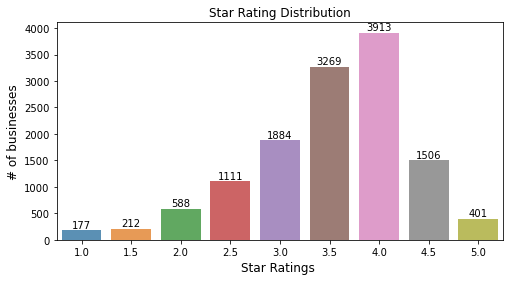

In [90]:
#Get the distribution of the ratings
x=eda_df['rating'].value_counts()
x=x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [91]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [92]:
eda_df['rating'].value_counts()

4.00    3913
3.50    3269
3.00    1884
4.50    1506
2.50    1111
2.00     588
5.00     401
1.50     212
1.00     177
Name: rating, dtype: int64

<AxesSubplot:xlabel='rating'>

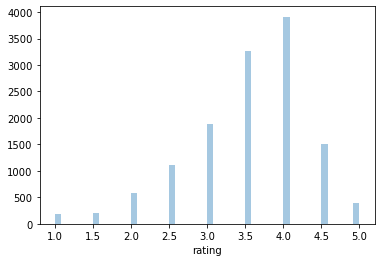

In [93]:
sns.distplot(eda_df.rating, kde=False)

In [94]:
cuisines = pd.DataFrame(eda_df['CUISINE DESCRIPTION'].value_counts())
cuisines.reset_index(inplace=True)
cuisines[0:10]

,index,CUISINE DESCRIPTION
0,American,2775
1,Chinese,1062
2,Pizza,922
3,Coffee/Tea,746
4,Italian,668
5,Japanese,499
6,Bakery Products/Desserts,430
7,Latin American,427
8,Mexican,412
9,Sandwiches,331


There are  82  different types of cuisines in NYC


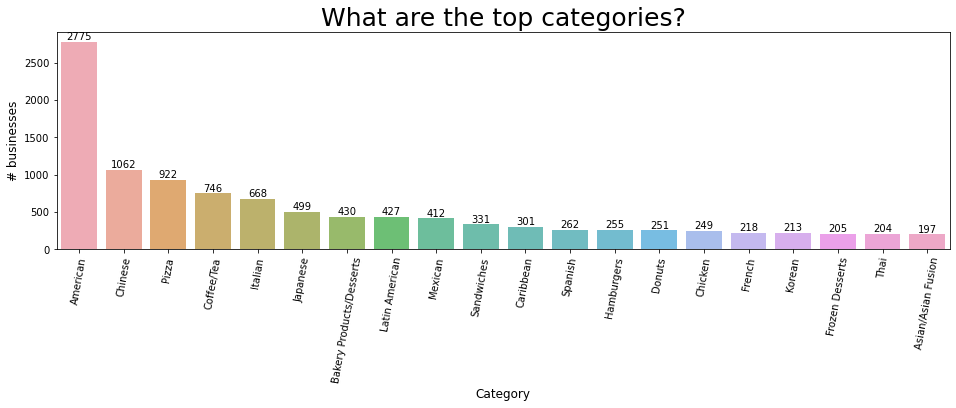

In [95]:
# What are the popular Cuisine categories?
cuisine_cats = eda_df['CUISINE DESCRIPTION']

x = cuisine_cats.value_counts()

print("There are ",len(x)," different types of cuisines in NYC")

#prep for chart
x = x.sort_values(ascending=False)
x = x.iloc[0:20]

#chart
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)#,color=color[5])
plt.title("What are the top categories?",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [96]:
eda_df.columns

Index(['CAMIS', 'DBA', 'CUISINE DESCRIPTION', 'BORO', 'BUILDING', 'STREET',
       'PHONE', 'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'Severe', 'id', 'review_count', 'rating',
       'transactions', 'price', 'Reviews', 'zipcode'],
      dtype='object')

In [97]:
# Most reviewed restaurants
eda_df[['CAMIS','id','DBA', 'review_count', 'rating']].sort_values(ascending=False, by="review_count")[0:50]

,CAMIS,id,DBA,review_count,rating
1108,50062888,V7lXZKBDzScDeGB8JmnzSA,KATZS DELICATESSEN (DEKALB MARKET),13458,4.00
1106,40732665,V7lXZKBDzScDeGB8JmnzSA,KATZ'S DELICATESSEN,13458,4.00
6845,50005848,44SY464xDHbvOcjDzRbKkQ,IPPUDO,10219,4.00
559,40402172,WIhm0W9197f_rRtDziq5qQ,LOMBARDI'S,6289,4.00
7658,50017243,UA2M9QFZghe-9th2KwLoWQ,BURGER & LOBSTER,5592,4.00
5036,41612461,ga6sRtE0l85iftw_5-W84Q,DOMINIQUE ANSEL BAKERY,4971,4.00
2308,41172734,U5hCNNyJmb7f3dmC1HTzSQ,JUNIOR'S RESTAURANT,4971,4.00
2306,41172734,U5hCNNyJmb7f3dmC1HTzSQ,JUNIOR'S RESTAURANT,4970,4.00
5034,41612461,ga6sRtE0l85iftw_5-W84Q,DOMINIQUE ANSEL BAKERY,4969,4.00
5155,41627819,xt4sa64WOrpJvZBDPNPNYg,JACOB'S PICKLES,4765,4.00


In [98]:
# Mapping prices to ordinal categories
price_dict={'$$$$': 4, '$$$': 3, '$$': 2, '$': 1}

eda_df['prices'] = eda_df['price'].map(price_dict)

In [99]:
# Imputing a 1 for NAN values
eda_df['prices'].fillna(1,inplace=True)

In [100]:
transactions = eda_df['transactions']

In [101]:
# Use ast module to convert string objects into list
transactions = transactions.apply(lambda x: ast.literal_eval(x))

In [102]:
# Change list into dicts
dcts = transactions.apply(lambda x: {c: 1 for c in x})

# Create new dataframe based on the list of dictionaries.
ohe_df = pd.DataFrame(dcts.tolist()).fillna(0)


In [103]:
ohe_df

,delivery,pickup,restaurant_reservation
0,1.00,0.00,0.00
1,0.00,0.00,0.00
2,1.00,1.00,0.00
3,1.00,1.00,0.00
4,1.00,1.00,0.00
...,...,...,...
13056,0.00,0.00,0.00
13057,1.00,0.00,0.00
13058,0.00,0.00,1.00
13059,1.00,1.00,0.00


In [104]:
# Concatenate dummy variales with the full dataset
eda_df = pd.concat([eda_df,ohe_df],axis=1)
eda_df.head()

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,review_count,rating,transactions,price,Reviews,zipcode,prices,delivery,pickup,restaurant_reservation
0,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,+17182875005,40.66,-73.96,309.00,40.00,32700.00,0,AMxMPBkWi20dn_1BRalahA,55,1.50,['delivery'],$,Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolutely would. The workers here are in efficient. They do not work the best possible way. They cause th...,11225,1.00,1.00,0.00,0.00
1,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,+17183723031,40.58,-73.98,313.00,47.00,34800.00,0,g8fAhVqBsC-BN6otcn85OA,55,4.50,[],NaN,"I had my wedding here a month ago and I would give Riviera 10 stars if I could. It was such a joy and ease to work with Adam, Tommy, and their staff. A true diamond in the rough of Coney Island a...",11224,1.00,0.00,0.00,0.00
2,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,+17184443838,40.62,-73.91,318.00,46.00,70000.00,0,Pe6MsH2DW0CXjvUtxUpI4A,54,3.00,"['pickup', 'delivery']",$$,We've recently discovered this gem on Uber Eats and they have the best sandwiches!!The broccoli rabe fried eggplant mozzarella sandwich was amazing. Having a fresh green veggie paired with a light...,11234,2.00,1.00,1.00,0.00
3,40356731,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0,Q18r5FKi2qkQhtKZqWR8ww,49,4.50,"['pickup', 'delivery']",$,We've ordered from these folks a number of times on Grubhub and have always been extremely satisfied. We've never been to the actual store but I have called over there a few times with some questi...,11226,1.00,1.00,1.00,0.00
4,40356731,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0,Q18r5FKi2qkQhtKZqWR8ww,49,4.50,"['delivery', 'pickup']",$,We've ordered from these folks a number of times on Grubhub and have always been extremely satisfied. We've never been to the actual store but I have called over there a few times with some questi...,11226,1.00,1.00,1.00,0.00


In [105]:
eda_df.drop(columns=['price','transactions'],inplace=True)

In [106]:
# Look at all the feautres compared to the 0 class and 1 class

In [107]:
labels_df = eda_df['Severe']
labels_df.shape

(13061,)

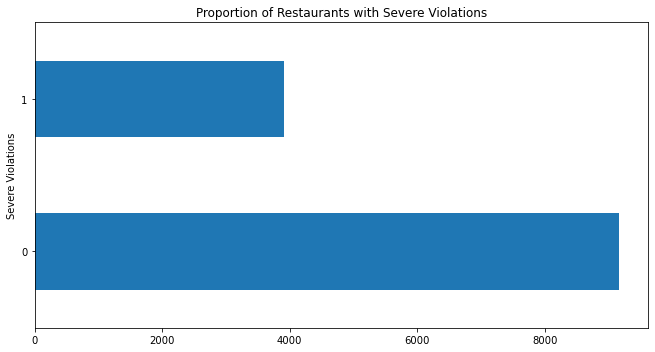

In [108]:
fig, ax = plt.subplots(figsize=(9.2, 5))

n_obs = labels_df.shape

(eda_df['Severe']
    .value_counts()
    .plot.barh(title="Proportion of Restaurants with Severe Violations", ax=ax)
)
ax.set_ylabel("Severe Violations")

fig.tight_layout()

In [109]:
boro_counts = (eda_df[['BORO', 'Severe']]
              .groupby(['BORO', 'Severe'])
              .size()
              .unstack('Severe')
         )
boro_counts

Severe,0,1
BORO,,
Bronx,664,312
Brooklyn,2025,918
Manhattan,4064,1683
Queens,2092,862
Staten Island,313,128


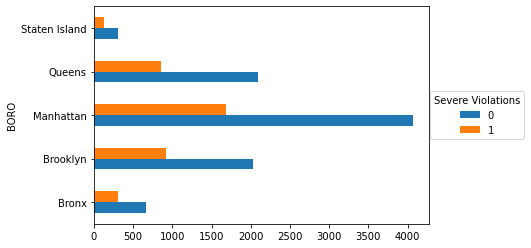

In [110]:
ax = boro_counts.plot.barh()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='Severe Violations'
);

In [111]:
severe_boro_counts = boro_counts.sum(axis='columns')
severe_boro_counts

BORO
Bronx             976
Brooklyn         2943
Manhattan        5747
Queens           2954
Staten Island     441
dtype: int64

In [112]:
boro_props = boro_counts.div(severe_boro_counts, axis='index')
boro_props

Severe,0,1
BORO,,
Bronx,0.68,0.32
Brooklyn,0.69,0.31
Manhattan,0.71,0.29
Queens,0.71,0.29
Staten Island,0.71,0.29


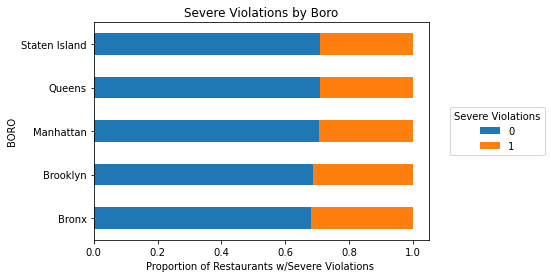

In [113]:
# Prototyping Stack Barh plot
ax = boro_props.plot.barh(stacked=True)
ax.set_title('Severe Violations by Boro')
ax.set_xlabel('Proportion of Restaurants w/Severe Violations ')
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='Severe Violations'
);

In [114]:
def violation_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of severe health and safety violations rate against 
    each feature of the data. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (eda_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)

    ax.legend().remove()

In [115]:
eda_df.columns

Index(['CAMIS', 'DBA', 'CUISINE DESCRIPTION', 'BORO', 'BUILDING', 'STREET',
       'PHONE', 'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'Severe', 'id', 'review_count', 'rating', 'Reviews',
       'zipcode', 'prices', 'delivery', 'pickup', 'restaurant_reservation'],
      dtype='object')

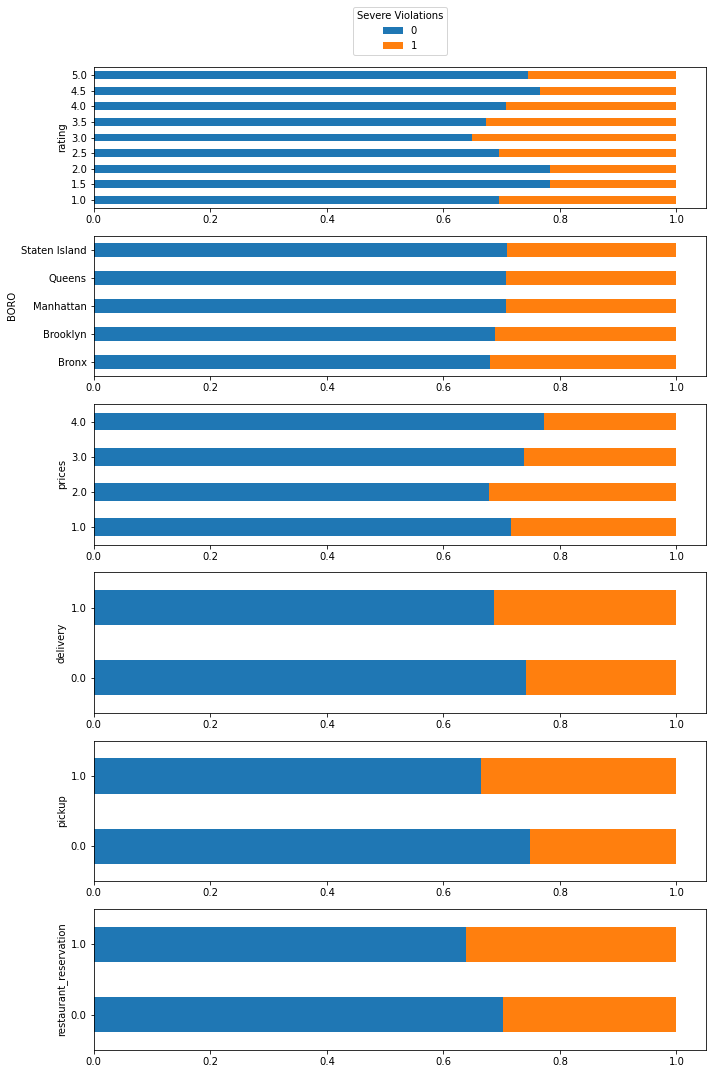

In [116]:
# Loop through several columns and plot against both severe violations.

cols_to_plot = [
    'rating',
    'BORO',
    'prices',
    'delivery',
    'pickup',
    'restaurant_reservation'
    
]

fig, ax = plt.subplots(
    len(cols_to_plot), figsize=(10,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    
    violation_rate_plot(
        col, 'Severe', eda_df, ax=ax[idx]
    )
    

ax[0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='Severe Violations'
)
fig.tight_layout()

In [117]:
# import street map
# https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

street_map = gpd.read_file('data/Borough_Boundaries/geo_export_392103e7-13e2-43bf-aaf0-7e5c6a24b7b2.shp')


In [118]:
geo_eda = eda_df.copy()

In [119]:
geo_eda.dropna(axis=0, subset=['Latitude','Longitude'], inplace=True)

In [120]:
# Remove the most extreme .1% latitudes, &
# the most extreme .1% longitudes

geo_eda = geo_eda[
 (geo_eda['Latitude'] >= np.percentile(geo_eda['Latitude'], 0.05)) & 
 (geo_eda['Latitude'] < np.percentile(geo_eda['Latitude'], 99.95)) &
 (geo_eda['Longitude'] >= np.percentile(geo_eda['Longitude'], 0.05)) & 
 (geo_eda['Longitude'] <= np.percentile(geo_eda['Longitude'], 99.95))
]

In [121]:
geo_eda = geo_eda[geo_eda['Longitude'] != 0]

In [122]:
geo_eda = geo_eda[geo_eda['Latitude'] != 0]

In [123]:
print(geo_eda['Longitude'].max())
print(geo_eda['Longitude'].min())
print(geo_eda['Latitude'].max())
print(geo_eda['Latitude'].min())

-73.700928057808
-74.241580331187
40.905490121208
40.511011068362


In [124]:
# designate coordinate system
crs = {'init':'epsg:4326'}
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(geo_eda['Longitude'], geo_eda['Latitude'])]

In [125]:
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(geo_eda, crs=crs, geometry = geometry)

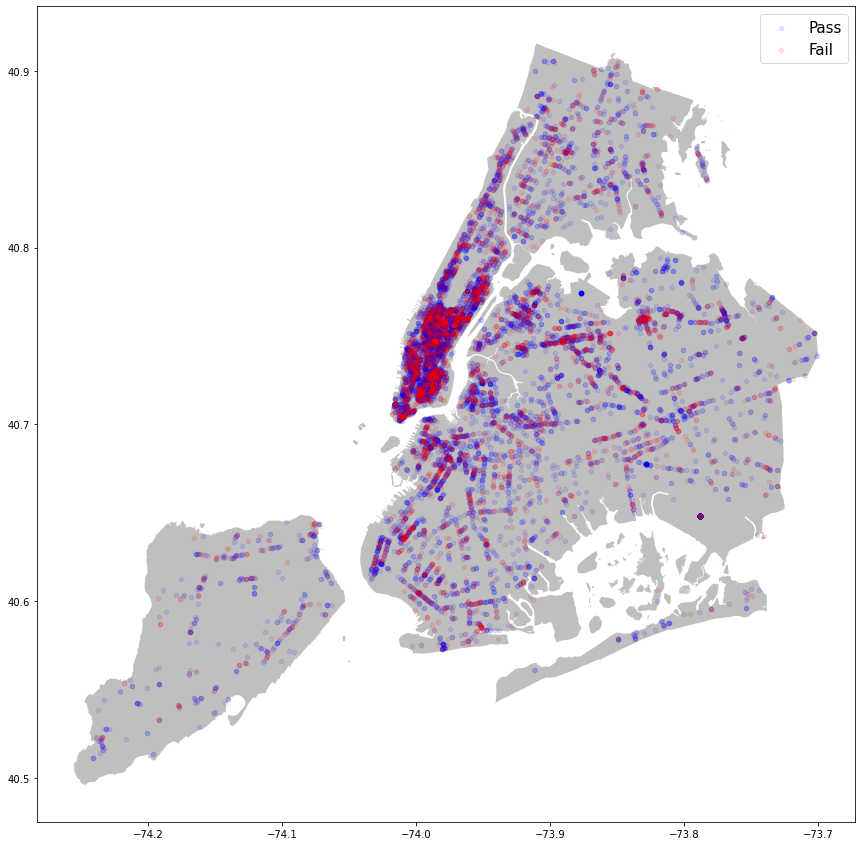

In [126]:
# Plotting map
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=.5,color='gray')
geo_df[geo_df['Severe'] == 0].plot(ax=ax, alpha=.1, markersize=20,color='blue',label='Pass')
geo_df[geo_df['Severe'] == 1].plot(ax=ax, alpha=.1, markersize=20,color='red',label='Fail')
plt.legend(prop={'size':15});

# Preprocessing For Further EDA

### Lets find most frequent words in Negative reviews

Basically, we will find most frequent words in reviews to get an overview of why users gave low ratings. These words could be related to those business attributes or services about which users are most unhappy.



In [127]:
txt_eda = df_1.copy()

In [128]:
passed_df = txt_eda.loc[txt_eda['Severe']==0]
passed_df

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews,zipcode
0,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,+17182875005,40.66,-73.96,309.00,40.00,32700.00,0,AMxMPBkWi20dn_1BRalahA,wendys-brooklyn-4,Wendy's,https://s3-media0.fl.yelpcdn.com/bphoto/fR70FbX4_WV2-ofhsE89YA/o.jpg,False,https://www.yelp.com/biz/wendys-brooklyn-4?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'burgers', 'title': 'Burgers'}]",1.50,"{'latitude': 40.662952, 'longitude': -73.961753}",['delivery'],$,"{'address1': '469 Flatbush Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11225', 'country': 'US', 'state': 'NY', 'display_address': ['469 Flatbush Ave', 'Brooklyn, NY 1122...",+17182875005,(718) 287-5005,Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolutely would. The workers here are in efficient. They do not work the best possible way. They cause th...,11225
1,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,+17183723031,40.58,-73.98,313.00,47.00,34800.00,0,g8fAhVqBsC-BN6otcn85OA,riviera-caterers-brooklyn,Riviera Caterers,https://s3-media0.fl.yelpcdn.com/bphoto/5qZ27Uarz2kNWxV3KktK1g/o.jpg,False,https://www.yelp.com/biz/riviera-caterers-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,55,"[{'alias': 'catering', 'title': 'Caterers'}]",4.50,"{'latitude': 40.57952, 'longitude': -73.98243}",[],NaN,"{'address1': '2780 Stillwell Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11224', 'country': 'US', 'state': 'NY', 'display_address': ['2780 Stillwell Ave', 'Brooklyn, NY ...",+17183723031,(718) 372-3031,"I had my wedding here a month ago and I would give Riviera 10 stars if I could. It was such a joy and ease to work with Adam, Tommy, and their staff. A true diamond in the rough of Coney Island a...",11224
2,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,+17184443838,40.62,-73.91,318.00,46.00,70000.00,0,Pe6MsH2DW0CXjvUtxUpI4A,wilkens-fine-foods-brooklyn-2,Wilkens Fine Foods,https://s3-media0.fl.yelpcdn.com/bphoto/gOyUSHz_oJWiN9Nw0AEpVg/o.jpg,False,https://www.yelp.com/biz/wilkens-fine-foods-brooklyn-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,54,"[{'alias': 'delis', 'title': 'Delis'}]",3.00,"{'latitude': 40.6199, 'longitude': -73.90685}","['pickup', 'delivery']",$$,"{'address1': '7114 Ave U', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11234', 'country': 'US', 'state': 'NY', 'display_address': ['7114 Ave U', 'Brooklyn, NY 11234']}",+17184443838,(718) 444-3838,We've recently discovered this gem on Uber Eats and they have the best sandwiches!!The broccoli rabe fried eggplant mozzarella sandwich was amazing. Having a fresh green veggie paired with a light...,11234
3,40356731,TASTE THE TROPICS ICE CREAM,Frozen Desserts,Brooklyn,1839,NOSTRAND AVENUE,+17188560821,40.64,-73.95,317.00,45.00,82800.00,0,Q18r5FKi2qkQhtKZqWR8ww,taste-the-tropics-usa-brooklyn,Taste the Tropics USA,https://s3-media0.fl.yelpcdn.com/bphoto/xW8S_DHdStqZiqjwQ_UUKw/o.jpg,False,https://www.yelp.com/biz/taste-the-tropics-usa-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,49,"[{'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}]",4.50,"{'latitude': 40.64083, 'longitude': -73.94835}","['pickup', 'delivery']",$,"{'address1': '1839 Nostrand Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11226', 'country': 'U

In [129]:
failed_df = txt_eda.loc[txt_eda['Severe']==1]
failed_df

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews,zipcode
5,40360076,CARVEL,Frozen Desserts,Brooklyn,203,CHURCH AVENUE,+17184389501,40.64,-73.98,312.00,39.00,49600.00,1,Xx-vjaRGaI6DO14VlerPew,carvel-brooklyn-3,Carvel,https://s3-media0.fl.yelpcdn.com/bphoto/GFZ0N9LdAcFYzedIBX9xlA/o.jpg,False,https://www.yelp.com/biz/carvel-brooklyn-3?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,32,"[{'alias': 'icecream', 'title': 'Ice Cream & Frozen Yogurt'}]",3.50,"{'latitude': 40.6434787, 'longitude': -73.9781848}","['pickup', 'delivery']",$,"{'address1': '203 Church Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11218', 'country': 'US', 'state': 'NY', 'display_address': ['203 Church Ave', 'Brooklyn, NY 11218']}",+17184389501,(718) 438-9501,"I love carvel there used to be carvel at Nostrand Avenue and Church Avenue back in the nineties that one closed down, but this location is located in the Kensington section of Brooklyn .there ice ...",11218
13,40363630,LORENZO & MARIA'S KITCHEN,Continental,Manhattan,1418,THIRD AVENUE,+12127941080,40.78,-73.96,108.00,5.00,14000.00,1,ngPB-OKxAk4b-0yBwRuT4g,lorenzo-and-marias-kitchen-new-york,Lorenzo & Marias Kitchen,https://s3-media0.fl.yelpcdn.com/bphoto/o0bPNsOo7GoVHga9ATkPhA/o.jpg,False,https://www.yelp.com/biz/lorenzo-and-marias-kitchen-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,34,"[{'alias': 'food', 'title': 'Food'}]",2.50,"{'latitude': 40.7753, 'longitude': -73.95678}",[],$$,"{'address1': '1418 3rd Ave', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10028', 'country': 'US', 'state': 'NY', 'display_address': ['1418 3rd Ave', 'New York, NY 10028']}",+12127941080,(212) 794-1080,"I have a love-hate relationship with this place. Over time, I came to know which dishes are really worth the highway-robbery-style pricing, and whether my visit -and the potential witnessing of th...",10028
23,40364362,21 CLUB,American,Manhattan,21,WEST 52 STREET,+12125827200,40.76,-73.98,105.00,4.00,10400.00,1,wFjELmsEYh972BG79HwMqA,upstairs-at-21-new-york,Upstairs at 21,https://s3-media0.fl.yelpcdn.com/bphoto/Lq-xykZkT13F8SxYSLLO8A/o.jpg,False,https://www.yelp.com/biz/upstairs-at-21-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,10,"[{'alias': 'newamerican', 'title': 'American (New)'}]",4.50,"{'latitude': 40.76037, 'longitude': -73.97741}",[],$$$$,"{'address1': '21 W 52nd St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10019', 'country': 'US', 'state': 'NY', 'display_address': ['21 W 52nd St', 'New York, NY 10019']}",+12125827200,(212) 582-7200,"Sophisticated atmosphere, prompt courteous staff, and food that is an out of this world experience. I was in Manhattan for work and the three of us made a Friday night reservation before we went ...",10019
24,40364362,21 CLUB,American,Manhattan,21,WEST 52 STREET,+12125827200,40.76,-73.98,105.00,4.00,10400.00,1,RSGqAGFmgfoVssOBfkldXA,21-club-new-york,21 Club,https://s3-media0.fl.yelpcdn.com/bphoto/ZVUicCEhf-vI_9eZG3UPHw/o.jpg,True,https://www.yelp.com/biz/21-club-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,630,"[{'alias': 'tradamerican', 'title': 'American (Traditional)'}, {'alias': 'venues', 'title': 'Venues & Event Spaces'}]",3.50,"{'latitude': 40.76037, 'longitude': -73.97741}",[],$$$$,"{'address1': '21 W 52nd St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10019', 'country': 'US', 'state': 'NY', 'display_address': ['21 W 52nd S

In [130]:
passed_corpus = passed_df['Reviews'].to_list()
passed_corpus[:5]

['Forgot my root beer and the burger tasted very weird.If I can give this place no stars I absolutely would. The workers here are in efficient. \xa0They do not work the best possible way. They cause the wait to be longer than it needs to be. If you can avoid this Wendy\'s definitely do so. It\'ll make your lives happier. There is no need for this place to be the way that it is. It\'s fast food. Not slow food.The service I just received from this establishment was incredibly terrible. My entire order was incorrect and nothing was done to right the situation, I am allergic to mayonnaise and my sandwich (the wrong one of course) was smothered in it. I just don\'t understand how businesses can get away with this kind of the treatment towards the clientele that keep them running and often thriving during these harsh times..I Just Ordered From This Place - First Time Ever Doing Any Kind Of Take Out With them And First Time In A Long Ass Time Even Getting Anything Outta There Honestly.., I Me

In [131]:
failed_corpus = failed_df['Reviews'].to_list()
failed_corpus[:5]

["I love carvel there used to be carvel at Nostrand Avenue and Church Avenue back in the nineties that one closed down, but this location is located in the Kensington section of Brooklyn .there ice cream is great, I love coming here to this location I'll definitely mind coming back in heartbeat. Staff members are cool too! \xa0(their delivery here as well I'm not sure if it's from Grubhub, uber eats, door dash, postmates, etc )- call in double check P.S. something about Carvel ice cream that does it, no offense Baskin Robbins .....Lol !!!!( all dough I could go to the shop and stop supermarket and get a carvel ice cream cake box I prefer to come here, instead ).Very convenient by the MTA transportation:Subway:F, G-Trains. Church avenue. Train station.Bus:B35 ,B67,B103.Had the vanilla ice cream it tasted off ... Now I'm home at 3am in the morning with food poisoning. Be wary..Cousin & I went to polish off our dinner with some ice cream. Best sundaes we ever had. The amount of fudge was 

In [132]:
# Tokenizing the corpus of review text from restaurants that have severly failed their inspection
failed_tokens = word_tokenize(','.join(failed_corpus))


In [133]:
# Tokenizing the corpus of review text from restaurants that have not severly  their inspection
passed_tokens = word_tokenize(','.join(passed_corpus))

In [134]:
# Importing English stop words
stopwords_list = stopwords.words('english')
# Add punctuation marks to the stopwords_list
stopwords_list.extend(string.punctuation)
additional_punc = ['“','”','...',"''",'’','``']
stopwords_list.extend(additional_punc)
restaurant_words = ['restaurant', 'place', 'food', 'drink']
stopwords_list.extend(restaurant_words)

In [135]:
# Removing stopwords from failed_corpus
stopped_failed_tokens = [w.lower() for w in failed_tokens if w.lower() not in stopwords_list]
stopped_failed_tokens[:10]

['love',
 'carvel',
 'used',
 'carvel',
 'nostrand',
 'avenue',
 'church',
 'avenue',
 'back',
 'nineties']

In [136]:
# Removing stopwords from passed_corpus
stopped_passed_tokens = [w.lower() for w in passed_tokens if w.lower() not in stopwords_list]
stopped_passed_tokens[:10]

['forgot',
 'root',
 'beer',
 'burger',
 'tasted',
 'weird.if',
 'give',
 'stars',
 'absolutely',
 'would']

In [137]:
# Creating FreqDist from stopped_failed_tokens
freq_failed = FreqDist(stopped_failed_tokens)
freq_failed.most_common(15)

[("n't", 27371),
 ("'s", 24690),
 ('..', 22707),
 ('good', 20802),
 ('like', 13681),
 ('great', 12793),
 ('one', 11126),
 ('order', 11084),
 ('chicken', 10993),
 ('would', 10692),
 ('time', 10682),
 ('get', 10465),
 ('service', 10413),
 ('also', 10159),
 ('really', 9961)]

In [138]:
# Creating FreqDist from stopped_passed_tokens
freq_passed = FreqDist(stopped_passed_tokens)
passed_bar = freq_passed.most_common(15)

In [139]:
# Creating FreqDist from stopped_passed_tokens
passed_bar_count = [x[1] for x in freq_passed.most_common(25)]
passed_bar_words = [x[0] for x in freq_passed.most_common(25)]

In [140]:
# Creating FreqDist from stopped_failed_tokens
failed_bar_count = [x[1] for x in freq_failed.most_common(25)]
failed_bar_words = [x[0] for x in freq_failed.most_common(25)]

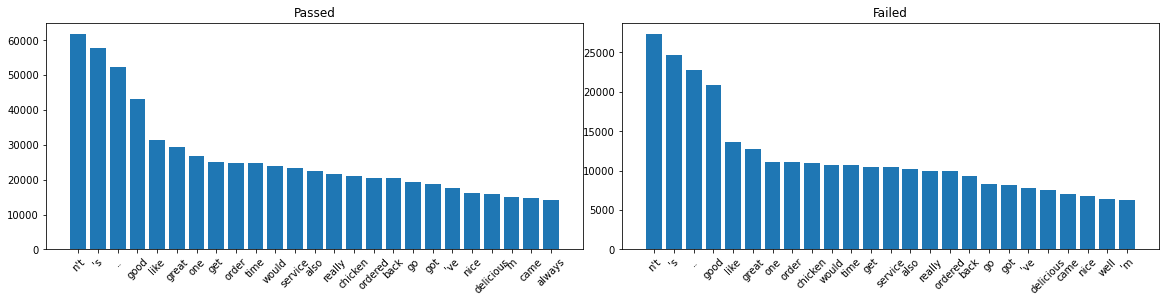

In [141]:
new_fig = plt.figure(figsize=(16,4))

ax = new_fig.add_subplot(121)
ax2 = new_fig.add_subplot(122)

ax.bar(passed_bar_words,passed_bar_count)
ax2.bar(failed_bar_words,failed_bar_count)

ax.title.set_text('Passed')
ax2.title.set_text('Failed')

for ax in new_fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
plt.tight_layout(pad=0)

plt.show()

In [142]:
# Functionizing wordcloud generator
def wordcloud_generator(tokens, collocations=False, background_color='black', 
                       colormap='Reds', display=True):

    
    # Initalize a WordCloud
    wordcloud = WordCloud(collocations=collocations, 
                          background_color=background_color, 
                          colormap=colormap, 
                          width=500, height=300)

    # Generate wordcloud from tokens
    wordcloud.generate(','.join(tokens))

    # Plot with matplotlib
    if display:
        plt.figure(figsize = (12, 15), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis('off');
        
    return wordcloud
    

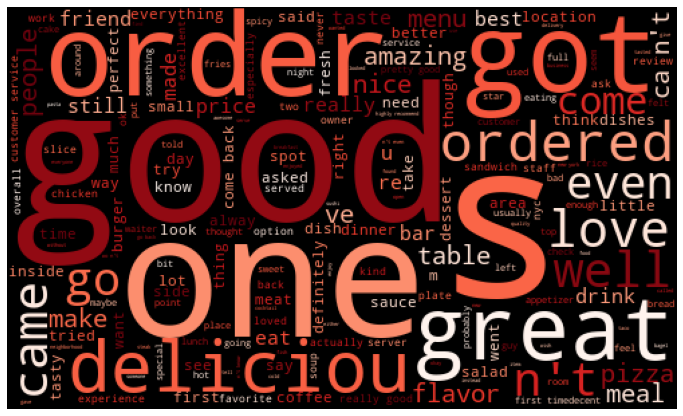

In [143]:
# Generating a WordCloud for reviews from restaurants that have failed their inspection
failed_cloud = wordcloud_generator(stopped_failed_tokens, collocations=True)

In [ ]:
# Generate a WordCloud from reviews of restaurants that have not severely failed an inspection
passsed_cloud = wordcloud_generator(stopped_passed_tokens, colormap='Greens',
                                     collocations=True)

# Preprocessing For Modeling

In [ ]:
df_1.columns

In [ ]:
# Dropping unneccessary columns
model_df = df_1.drop(columns=['CAMIS', 'DBA', 'CUISINE DESCRIPTION', 'BORO', 'BUILDING', 'STREET',
       'PHONE', 'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'alias', 'name', 'image_url',
       'is_closed', 'url', 'review_count', 'categories', 'rating',
       'coordinates', 'transactions', 'price', 'location', 'phone',
       'display_phone', 'zipcode'])

In [ ]:
model_df.head(3)

In [ ]:
model_df['Reviews'].isna().sum()

In [ ]:
# Checking Class Balance
model_df['Severe'].value_counts()

In [ ]:
# Make X and y
y = model_df['Severe'].copy()
X = model_df['Reviews'].copy()

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)


In [ ]:
# Using NLTK's Regular Expressions Tokenizer from nltk.tokenize
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
tokenizer

In [ ]:
# Creating a Count Vectorizer the RE tokenizer's .tokenize method
vectorizer = CountVectorizer(lowercase=True, tokenizer=tokenizer.tokenize,
                            stop_words=stopwords_list, min_df=0.1, 
                             ngram_range=(1,2))

In [ ]:
# Vectorizing the data and saving X_train_bow and X_test_bow
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)
X_train_bow

In [ ]:
# Saving sparse matrix into a DataFrame
df_cv = pd.DataFrame(X_train_bow.toarray(), 
                     columns=vectorizer.get_feature_names())

In [ ]:
df_cv.iloc[0].sort_values(ascending=False)[:10]

In [ ]:
tf_vec = TfidfVectorizer(lowercase=True, tokenizer=tokenizer.tokenize,
                         stop_words=stopwords_list, min_df=0.05, 
                         max_df=0.95, ngram_range=(1,2))
X = tf_vec.fit_transform(X_train)

df_tfidf = pd.DataFrame(X.toarray(), columns = tf_vec.get_feature_names())

In [ ]:
df_tfidf.iloc[0].sort_values(ascending=False)[:10]

In [ ]:
X_train.iloc[0]

# Models

## Bag-of-Words Model



In [ ]:
# Create and fit a Decision Tree Classifier
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=10)
dt.fit(X_train_bow,y_train)

In [ ]:
# Extract predictions for the train and test sets
y_hat_test = dt.predict(X_test_bow)


In [ ]:
def evaluate_model(y_test,y_hat_test,X_test,clf=None,
                  scoring=metrics.recall_score,verbose=False,
                  scorer=False,classes=['Passed','Failed']):
    """Quick/simple classification model evaluation"""

    print(metrics.classification_report(y_test,y_hat_test,
                                        target_names=classes))
    
    metrics.plot_confusion_matrix(clf,X_test,y_test,normalize='true',
                                 cmap='Blues',display_labels=classes)
    plt.show()
    if verbose:
        print("MODEL PARAMETERS:")
        print(pd.Series(dt.get_params()))
        
    if scorer:
        
        return scoring(y_test,y_hat_test)

In [ ]:
# Evaluating the moodel using function
evaluate_model(y_test,y_hat_test,X_test_bow,dt)

In [ ]:
# Plot the top 25 most important features
with plt.style.context('seaborn-talk'):

# Get Feature Importance
    importance = pd.Series(dt.feature_importances_,index=vectorizer.get_feature_names())

# Sort values 


# Take the .tail 25 and plot kind='barh'
    importance.sort_values().tail(25).plot(kind='barh')

In [ ]:
count_vect = CountVectorizer()
tf_transform = TfidfTransformer(use_idf=True)

text_pipe = Pipeline(steps=[
    ('count_vectorizer',count_vect),
    ('tf_transformer',tf_transform)])

full_pipe = Pipeline(steps=[
    ('text_pipe',text_pipe),
    ('clf',DecisionTreeClassifier(class_weight='balanced'))
])
full_pipe

In [ ]:

## Preview current X_train
X_train_pipe = text_pipe.fit_transform(X_train)
X_test_pipe = text_pipe.transform(X_test)
X_train_pipe


In [ ]:
from sklearn import set_config

In [ ]:
set_config(display='diagram')

full_pipe

In [ ]:
from sklearn.model_selection import GridSearchCV
## Make a tokenizer with TweetTokenizer
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:'[a-z]+)?)")
vectorizer = CountVectorizer(ngram_range=[1,2])
## Make params Grid


params = {'text_pipe__tf_transformer__use_idf':[True, False],
         'text_pipe__count_vectorizer__tokenizer':[None,tokenizer.tokenize],
         'text_pipe__count_vectorizer__stop_words':[None,stopwords_list],
         'clf__criterion':['gini', 'entropy']}

## Make and fit grid
grid = GridSearchCV(full_pipe,params,cv=3)
grid.fit(X_train,y_train)
## Display best params
grid.best_params_

In [ ]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",
                      stop_words=stopwords_list, ngram_range=[1,2],
                      min_df=0.05, max_df=0.95)
X = vec.fit_transform(X_train)

df_cv = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df_cv

In [ ]:
## Evluate the best_estimator
best_pipe = grid.best_estimator_
y_hat_test = grid.predict(X_test)

In [ ]:
evaluate_model(y_test,y_hat_test,X_test,best_pipe)

## Getting Feature Importances


In [ ]:
X_train_pipe = text_pipe.fit_transform(X_train)
X_test_pipe = text_pipe.transform(X_test)
X_train_pipe

In [ ]:
X_train_pipe.shape

In [ ]:
features = text_pipe.named_steps['count_vectorizer'].get_feature_names()

In [ ]:
len(features)

In [ ]:
### Function to produce the model's coefficients

def eval_clf(model, X_test_tf,y_test,cmap='Reds',
                            normalize='true',classes=['Unvaccinated', 'Vaccinated'],figsize=(10,4),
                            X_train = None, y_train = None,):
    """Evaluates a scikit-learn binary classification model.

    Args:
        model ([type]): [description]
        X_test_tf ([type]): [description]
        y_test ([type]): [description]
        cmap (str, optional): [description]. Defaults to 'Reds'.
        normalize (str, optional): [description]. Defaults to 'true'.
        classes ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (8,4).
        X_train ([type], optional): [description]. Defaults to None.
        y_train ([type], optional): [description]. Defaults to None.
    """
    
    
    y_hat_test = model.predict(X_test_tf)
    print(metrics.classification_report(y_test, y_hat_test,target_names=classes))
    

    fig,ax = plt.subplots(ncols=2,figsize=figsize)
    plt.grid(False)
    plot_confusion_matrix(model, X_test_tf,y_test,cmap=cmap, 
                                  normalize=normalize,display_labels=classes,
                                 ax=ax[0])
    for a in ax:
        a.grid(False)   
        
    curve = metrics.plot_roc_curve(model,X_test_tf,y_test,ax=ax[1])
    curve.ax_.grid()
    curve.ax_.plot([0,1],[0,1],ls=':')
    fig.tight_layout()
    plt.show()
    
    ## Add comparing Scores if X_train and y_train provided.
    if (X_train is not None) & (y_train is not None):
        print(f"Training Score = {model.score(X_train,y_train):.2f}")
        print(f"Test Score = {model.score(X_test_tf,y_test):.2f}")

## TF-IDF Models


In [ ]:
## Make a Regular Expression Tokenizer from nltk.tokenize
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

In [ ]:
## Make a TfIdf Vectorizer using tweet tokenizer's .tokenize method
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                             stop_words=stopwords_list)

# Vectorize data and make X_train_tfidf and X_test_tfidf
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_train_tfidf


In [ ]:
tf_vec = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",min_df=0.05,
                         max_df=0.95,ngram_range=(1,2),stop_words=stopwords_list)
X = tf_vec.fit_transform(X_train)

df = pd.DataFrame(X.toarray(), columns = tf_vec.get_feature_names())
df.head()

### Modeling Baseline

In [ ]:
## Make and fit a decision tree  (class_weight='balanced')
dt = DecisionTreeClassifier(max_depth=6, class_weight='balanced')
dt.fit(X_train_tfidf,y_train)

In [ ]:
def evaluate_classification(model, X_test_tf,y_test,cmap='Blues',
                            normalize='true',classes=None,figsize=(10,4),
                            X_train = None, y_train = None,):
    """Evaluates a scikit-learn binary classification model.

    Args:
        model (classifier): any sklearn classification model.
        X_test_tf (Frame or Array): X data
        y_test (Series or Array): y data
        cmap (str, optional): Colormap for confusion matrix. Defaults to 'Greens'.
        normalize (str, optional): normalize argument for plot_confusion_matrix. 
                                    Defaults to 'true'.
        classes (list, optional): List of class names for display. Defaults to None.
        figsize (tuple, optional): figure size Defaults to (8,4).
        
        X_train (Frame or Array, optional): If provided, compare model.score 
                                for train and test. Defaults to None.
        y_train (Series or Array, optional): If provided, compare model.score 
                                for train and test. Defaults to None.
    """
    
    ## Get Predictions and Classification Report
    y_hat_test = model.predict(X_test_tf)
    print(metrics.classification_report(y_test, y_hat_test,target_names=classes))
    
    ## Plot Confusion Matrid and roc curve
    fig,ax = plt.subplots(ncols=2, figsize=figsize)
    metrics.plot_confusion_matrix(model, X_test_tf,y_test,cmap=cmap, 
                                  normalize=normalize,display_labels=classes,
                                 ax=ax[0])
    
    ## if roc curve erorrs, delete second ax
    try:
        curve = metrics.plot_roc_curve(model,X_test_tf,y_test,ax=ax[1])
        curve.ax_.grid()
        curve.ax_.plot([0,1],[0,1],ls=':')
        fig.tight_layout()
    except:
        fig.delaxes(ax[1])
    plt.show()
    
    ## Add comparing Scores if X_train and y_train provided.
    if (X_train is not None) & (y_train is not None):
        print(f"Training Score = {model.score(X_train,y_train):.2f}")
        print(f"Test Score = {model.score(X_test_tf,y_test):.2f}")
        
    
def plot_importance(tree, X_train_df, top_n=20,figsize=(10,10)):
    
    df_importance = pd.Series(tree.feature_importances_,
                              index=X_train_df.columns)
    df_importance.sort_values(ascending=True).tail(top_n).plot(
        kind='barh',figsize=figsize,title='Feature Importances',
    ylabel='Feature',)
    return df_importance

In [ ]:
## Evaluate Model using function
evaluate_classification(dt,X_test_tfidf,y_test,X_train=X_train_tfidf,
                        y_train=y_train)

In [ ]:
## Make a text preprocessing pipeline
text_pipe = Pipeline(steps=[
    ('count_vectorizer',CountVectorizer()),
    ('tf_transformer',TfidfTransformer(use_idf=True))
])
text_pipe

In [ ]:
## Test out the text pipeline on X_train
X_train_pipe = text_pipe.fit_transform(X_train)
X_test_pipe = text_pipe.transform(X_test)
X_train_pipe

In [ ]:
## Make a full pipeline with the random forest model as the second step
full_pipe = Pipeline([('text_pipe',text_pipe),
                     ('clf',DecisionTreeClassifier(max_depth=6,class_weight='balanced'))])
full_pipe

In [ ]:
## Modeling with full pipeline
full_pipe.fit(X_train,y_train)
evaluate_classification(full_pipe,X_test,y_test,X_train=X_train, y_train=y_train)

In [ ]:
# DTREE Model

In [ ]:
# SVM Model

##  Deep NLP Models


### Word2Vec

In [191]:
# Minimally preprocessing for Deep NLP with all lower case
# Keeping stopwords to help provide firther word context
lower_data = model_df['Reviews'].map(lambda x: simple_preprocess(x.lower(),
                                                                 deacc=True))

In [192]:
# 
w2v_model = Word2Vec(lower_data,size=50,window=3,min_count=3,sg=0)

In [193]:
w2v_model

In [194]:
examples = w2v_model.corpus_count

In [195]:
# Training Word2Vec Model
w2v_model.train(lower_data,total_examples=examples,epochs=50,)

(464240554, 610253300)

In [196]:
# Get the keyed vector
wv = w2v_model.wv
len(wv.vocab)

33298

We have 33,298 trained words.

In [197]:
wv.most_similar(negative=['sick'])

[('crudite', 0.5211197733879089),
 ('offset', 0.5062964558601379),
 ('serviceprice', 0.49563947319984436),
 ('is', 0.4898544251918793),
 ('offers', 0.48499834537506104),
 ('albeit', 0.4783792197704315),
 ('quant', 0.4731408953666687),
 ('mexodus', 0.47181084752082825),
 ('includes', 0.47130322456359863),
 ('namely', 0.4589795768260956)]

In [198]:
wv.most_similar(negative=['poison'])

[('pere', 0.5644559860229492),
 ('yogurty', 0.5012726783752441),
 ('doughier', 0.4855877161026001),
 ('waaayyyy', 0.48042428493499756),
 ('slightly', 0.47897931933403015),
 ('crispy', 0.47088611125946045),
 ('crisp', 0.4691073000431061),
 ('deconstructed', 0.4550844132900238),
 ('buckys', 0.45102351903915405),
 ('chilly', 0.4506188631057739)]

In [199]:
wv.most_similar(negative=['health'])

[('skinny', 0.5029502511024475),
 ('goodworth', 0.4860212206840515),
 ('petite', 0.4592294991016388),
 ('plasticy', 0.44577306509017944),
 ('sweet', 0.44104284048080444),
 ('towelettes', 0.43190431594848633),
 ('bedrock', 0.42919042706489563),
 ('tart', 0.4178142547607422),
 ('gooood', 0.4148668050765991),
 ('discombobulated', 0.41178783774375916)]

## Word2Vec Modeling

In [200]:
X = model_df['Reviews']
y = model_df['Severe']
y.tail()

13056    1
13057    1
13058    0
13059    0
13060    0
Name: Severe, dtype: int64

In [201]:
# Train Test Split before any pre-processing
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42) 
X_train.shape,y_test.shape

((9795,), (3266,))

In [202]:
pd.Series(y_test).value_counts(normalize=True)

0   0.69
1   0.31
Name: Severe, dtype: float64

In [203]:
## Class balance
y_train.value_counts(1)

0   0.70
1   0.30
Name: Severe, dtype: float64

In [204]:
# Calculating weights 

weights = compute_class_weight('balanced',np.unique(y_train), y_train)
weights_dict = dict(zip( np.unique(y_train),weights))
weights_dict

{0: 0.7096797565570208, 1: 1.692294402211472}

In [205]:
# OneHotEncoding target variable for NN
y_train_seq = to_categorical(y_train)
y_test_seq = to_categorical(y_test)
y_train_seq.shape

(9795, 2)

In [206]:
# Tokenizing text with Keras tokenizer
max_words = 50000
tokenizer = text.Tokenizer(num_words=max_words)

In [207]:
tokenizer.fit_on_texts(X_train)

In [208]:
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [209]:
# Finding the longest sequence for optimaiztion
max_sequence_length = max(list(map(lambda x: len(x),[*train_sequences,*test_sequences])))
max_sequence_length

10755

In [225]:
# Padding sequences because NN require same sizes
X_train_seq = keras.preprocessing.sequence.pad_sequences(train_sequences, 
                                     maxlen=max_sequence_length)
X_test_seq = keras.preprocessing.sequence.pad_sequences(test_sequences, 
                                    maxlen=max_sequence_length)

In [226]:
model = Sequential()

In [227]:
embedding_size = 128
model.add(Embedding(20000, embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(41, activation='softmax'))

In [228]:
# def get_earlystop(monitor='val_accuracy',patience=3, restore_best_weights=False):
#     """"""
#     args = locals()
#     return EarlyStopping(**args)

# get_earlystop.__doc__+=EarlyStopping.__doc__
# get_earlystop

In [234]:
#  #where codealong get this?
# def make_model1(EMBEDDING_SIZE = 128):
#     model=Sequential()

#     model.add(Embedding(max_words, EMBEDDING_SIZE))
#     model.add(LSTM(50,return_sequences=False))
# #     model.add(GlobalMaxPool1D()) 
#     model.add(Dropout(0.5))
#     model.add(Dense(25, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(2, activation='softmax'))

#     model.compile(loss='categorical_crossentropy', 
#                   optimizer='adam', 
#                   metrics=['accuracy'])
# #     display(model.summary())
#     return model

In [235]:
model = make_model1()
history = model.fit(X_train_seq, y_train_seq, epochs=5,
                    batch_size=32, validation_split=0.2,callbacks=get_earlystop(),
                   class_weight=weights_dict)

Epoch 1/10
245/245 [==============================] - 3664s 15s/step - loss: 0.6940 - accuracy: 0.4501 - val_loss: 0.6705 - val_accuracy: 0.6912
Epoch 2/10
  3/245 [..............................] - ETA: 1:04:01 - loss: 0.7406 - accuracy: 0.6250

KeyboardInterrupt: 

In [236]:
y_hat_test = model.predict(X_test_seq).argmax(axis=1)
y_hat_test[:5]

103/103 [==============================] - 171s 2s/step


array([0, 0, 0, 0, 0])

In [237]:
y_test_seq.argmax(axis=1)

array([0, 0, 0, ..., 0, 0, 1])

## Pretrained Vector Models

In [239]:
target = model_df['Severe']

In [240]:
data = model_df['Reviews'].map(word_tokenize).values

In [241]:
total_vocabulary = set(word for review in data for word in review)

In [242]:
len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 180157 unique tokens in the dataset.


In [243]:
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [244]:
# testing vecotrizer
glove['food']

array([ 0.47222  , -0.44545  , -0.51833  , -0.26818  ,  0.44427  ,
       -0.25108  , -0.99282  , -0.90198  ,  1.8729   ,  0.039081 ,
        0.14284  ,  0.074878 ,  1.0543   , -0.3203   ,  1.0722   ,
        0.44323  ,  0.0099484,  0.15754  ,  0.51399  , -0.77668  ,
        0.924    ,  0.010958 ,  0.58815  ,  0.23078  , -0.34281  ,
       -0.88444  , -0.31492  ,  0.12661  ,  1.1445   ,  0.60775  ,
        3.4344   ,  0.63561  , -0.13832  ,  0.28045  , -0.16181  ,
        0.77541  , -0.49888  ,  0.4602   ,  0.91799  ,  0.29007  ,
        0.06884  ,  0.59978  ,  0.53967  , -0.061752 ,  1.2975   ,
        0.92323  , -0.80945  ,  0.34932  ,  0.33934  ,  0.25499  ],
      dtype=float32)

### Mean Word Embeddings


In [245]:
# Adapted from https://github.com/learn-co-curriculum/dsc-classification-with-word-embeddings-codealong
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
     
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

Passing the mean vectorizer class created above in the first step of pipeline. To be followed it up with the model classifying the data fed in.

In [246]:
# Creating pipeline objects that make use of the mean embedding vectorizer
rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])

In [247]:
# Saving a list for each pipeline name and object
models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr)]

In [248]:
# Storing cross validation scores with sklearn's cross_val_score() function
cv_scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]
cv_scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


[('Random Forest', 0.6923663864387608),
 ('Support Vector Machine', 0.7011714304941705),
 ('Logistic Regression', 0.7004823502846478)]

## Deep Learning With Word Embeddings

In [250]:
# OneHotEncoding target variables
y = pd.get_dummies(target).values

In [252]:
# Using Keras' tokenizer, converting to sequences and padding the sequences to equal length
# Limiting vocabulary size to the 50000 most important words.
tokenizer = text.Tokenizer(num_words=50000)
tokenizer.fit_on_texts(list(model_df['Reviews']))
list_tokenized_reviews = tokenizer.texts_to_sequences(model_df['Reviews'])
X_t = keras.preprocessing.sequence.pad_sequences(list_tokenized_reviews, maxlen=1000)


### Building Neural Network

In [254]:
# Our output layer is a Dense layer with 41 neurons, which corresponds to the 41 possible classes in the labels. You set the activation function for this output layer to 'softmax', so that the network will output a vector of predictions, where each element's value corresponds to the percentage chance that the example is the class that corresponds to that element, and where the sum of all elements in the output vector is 1.
model = Sequential()

In [255]:
# Feeding data into an LSTM layer,then a Dense layer and an output layer
embedding_size = 128
model.add(Embedding(50000, embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(41, activation='softmax'))

In [256]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [1]:
model.summary()

NameError: name 'model' is not defined

In [258]:
model.fit(X_t, y, epochs=3, batch_size=32, validation_split=0.1)

Epoch 1/3


ValueError: in user code:

    File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/keras/engine/training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/keras/engine/training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/keras/losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/keras/losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/keras/losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/keras/backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 2) and (None, 41) are incompatible


In [259]:
EMBEDDING_SIZE = 128 #where codealong get this?

embedding_matrix = np.zeros((len(total_vocabulary) + 1, EMBEDDING_SIZE))
for word, i in enumerate(total_vocabulary):#.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
        
embedding_layer = Embedding(len(total_vocabulary) + 1,
                            EMBEDDING_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

NameError: name 'MAX_SEQUENCE_LENGTH' is not defined

In [260]:
embedding_layer = Embedding(len(total_vocabulary) + 1,
                            embedding_size,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

NameError: name 'MAX_SEQUENCE_LENGTH' is not defined

In [261]:
wv.get_keras_embedding()

In [262]:
#where codealong get this?
def make_model_wv(wv):
    model=Sequential()

    model.add(wv.get_keras_embedding())
    model.add(LSTM(50,return_sequences=False))

    # model.add(GlobalMaxPool1D()) 
    # model.add(Dropout(0.5))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy',#'categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

In [263]:
model = make_model_wv(wv)
history = model.fit(X_train_seq, y_train_seq, epochs=50,
                    batch_size=32, validation_split=0.2,
                    callbacks=get_earlystop(),
                   class_weight=weights_dict)

y_hat_test = model.predict(X_test_seq).argmax(axis=1)
kg.evaluate_model(y_test_seq,y_hat_test,history)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 50)          1664900   
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 25)                1275      
                                                                 
 dropout_8 (Dropout)         (None, 25)                0         
                                                                 
 dense_9 (Dense)             (None, 2)                 52        
                                                                 
Total params: 1,686,427
Trainable params: 21,527
Non-trainable params: 1,664,900
_________________________________________________________________


TypeError: 'module' object is not callable

# Conclusions

## Best Model Results

## Takeaways and Recommended Actions

##  Next Steps and Future Work